# **Casos de Covid19 e o clima no Brasil - Uma analise correlativa**
[texto do link](https://) 

Este notebook tenta explorar a existência de correlação entre a quantidade de casos no Brasil e a temperatura e umidade focando em algumas regiões.

De acordo com a OMS, diversos fatores ambientais podem influenciar a disseminação de doenças transmissíveis que podem causar epidemias. Os considerados mais importantes são:
1. Abastecimento de água
2. Instalações sanitárias
3. Comida
4. Clima

Temos como hipótese que a quantidade de casos e a disseminação do vírus são afetados pelo clima. A temperatura e a umidade, alteradas ao longo das estações, afetam o número de incidentes de contração do vírus.

O que se segue é uma estimativa dessa relação com base no número de casos confirmados no Brasil em XX de XXXXX de 2020 e na temperatura e umidade de suas regiões. 
Queremos também responder a questão de pesquisa que é possível que em altos valores de temperatura e umidade temos uma redução no número de novos casos?

# CONFIGURAÇÕES DO PROJETO


## Instalação das dependencias

In [ ]:
!pip install geopandas
!pip install contextily
!pip install seaborn==0.11.0
!pip install statsmodels==0.12.1

#Contextily for basemap plotting 
#!apt-get install libproj-dev proj-data proj-bin
#!apt-get install libgeos-dev
#!pip install cython
#!pip install cartopy
#!pip3 install contextily==1.0rc2
#!pip install descartes
#!pip install mapclassify

     |████████████████████████████████| 962 kB 14.6 MB/s 
     |████████████████████████████████| 6.4 MB 67.4 MB/s 
     |████████████████████████████████| 1.0 MB 61.8 MB/s 
     |████████████████████████████████| 14.8 MB 89.9 MB/s 
     |████████████████████████████████| 82 kB 27.8 MB/s 
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 18.3 MB 8.5 MB/s 
     |████████████████████████████████| 112 kB 66.6 MB/s 
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 283 kB 16.2 MB/s 
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 9.5 MB 14.5 MB/s 
     |████████████████████████████████| 231 kB 26.3 MB/s 
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.


## Importa bibliotecas do projeto

In [ ]:
import glob
import gzip
import os
from datetime import date

import contextily
import geopandas
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab as plot
import requests
import seaborn as sns
from geopandas import GeoDataFrame
from matplotlib.pyplot import cm, draw, figure, plot, show
from mpl_toolkits.mplot3d import Axes3D
from shapely.geometry import LineString, Point
from statsmodels.regression.linear_model import OLS

%matplotlib inline



# EXTRAÇÃO DOS DADOS

## Importa os dados do Brasil.io sobre o covid-19 no Brasil

In [ ]:
data_full = requests.get('https://data.brasil.io/dataset/covid19/caso_full.csv.gz')

#arquivo em modo de escrita de binário(wb) é gravado no conteúdo da variavél data_full
open('caso_full.csv.gz', 'wb').write(data_full.content)

with gzip.open('caso_full.csv.gz') as f:
    df_covid = pd.read_csv(f)

## Tratamento dos dados do Covid-19

In [ ]:
#selecionando apenas as colunas que serão utilizadas para analise inicial dos dados
df_covid = df_covid[['state', 'city', 'date', 'order_for_place','is_last','epidemiological_week','estimated_population_2019','last_available_confirmed','last_available_death_rate','last_available_deaths', 'new_confirmed', 'new_deaths']]

df_covid.head()

,state,city,date,order_for_place,is_last,epidemiological_week,estimated_population_2019,last_available_confirmed,last_available_death_rate,last_available_deaths,new_confirmed,new_deaths
0,SP,São Paulo,2020-02-25,1,False,9,12252023.0,1,0.0,0,1,0
1,SP,NaN,2020-02-25,1,False,9,45919049.0,1,0.0,0,1,0
2,SP,São Paulo,2020-02-26,2,False,9,12252023.0,1,0.0,0,0,0
3,SP,NaN,2020-02-26,2,False,9,45919049.0,1,0.0,0,0,0
4,SP,São Paulo,2020-02-27,3,False,9,12252023.0,1,0.0,0,0,0


In [ ]:
#As 5 semanas epidemiologias/datas que mais tiveram casos confirmados e mortes no Brasil 
top5_datas = df_covid.groupby(['epidemiological_week', 'date'])['new_confirmed', 'new_deaths'].sum().sort_values(by='new_confirmed', ascending=False)[1:6]
top5_datas

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


new_confirmed  new_deaths
epidemiological_week date                                 
47                   2020-11-20         157574        2790
51                   2020-12-17         138171        2127
                     2020-12-16         135779        1972
30                   2020-07-22         132300        2592
52                   2020-12-24         124524        1691

### Criação da coluna REGION, onde são separados os dados de cada estado por sua região

In [ ]:
norte = ["AC", "AM", "AP", "PA", "RO", "RR", "TO"]
nordeste = ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE']
sudeste = ['ES', 'MG', 'RJ', 'SP']
sul = ['PR', 'RS', 'SC']
centro_oeste = ['DF', 'GO', 'MT', 'MS']

regiao = [nordeste, norte, sudeste, sul, centro_oeste]
label_reg = ['Nordeste', 'Norte', 'Sudeste', 'Sul', 'Centro Oeste']

#aplica a coluna region para inserir cada estado na sua regiao
for r in range(len(regiao)) :
    for a in range(len(regiao[r])) :
        df_covid.loc[df_covid['state'].eq(regiao[r][a]), 'region'] = label_reg[r]


df_covid

,state,city,date,order_for_place,is_last,epidemiological_week,estimated_population_2019,last_available_confirmed,last_available_death_rate,last_available_deaths,new_confirmed,new_deaths,region
0,SP,São Paulo,2020-02-25,1,False,9,12252023.0,1,0.0000,0,1,0,Sudeste
1,SP,NaN,2020-02-25,1,False,9,45919049.0,1,0.0000,0,1,0,Sudeste
2,SP,São Paulo,2020-02-26,2,False,9,12252023.0,1,0.0000,0,0,0,Sudeste
3,SP,NaN,2020-02-26,2,False,9,45919049.0,1,0.0000,0,0,0,Sudeste
4,SP,São Paulo,2020-02-27,3,False,9,12252023.0,1,0.0000,0,0,0,Sudeste
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1382602,RS,NaN,2021-01-11,308,True,2,11377239.0,482062,0.0197,9498,1582,59,Sul
1382603,SC,NaN,2021-01-11,306,True,2,7164788.0,522478,0.0109,5677,1901,40,Sul
1382604,SE,NaN,2021-01-11,304,True,2,2298696.0,123836,0.0209,2585,1242,11,Nordeste
1382605,SP,NaN,2021-01-11,322,True,2,45919049.0,1549142,0.0312,48379,3010,28,Sudeste


In [ ]:
df_covid['region'].value_counts()

Nordeste        455251
Sudeste         410691
Sul             286171
Norte           118420
Centro Oeste    112074
Name: region, dtype: int64

<AxesSubplot:>

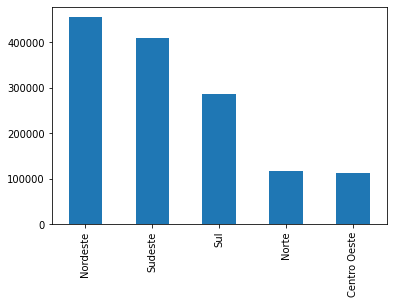

In [ ]:
df_covid['region'].value_counts().plot(kind='bar')

### Analise das regiões para ver quais de seus estados tiveram maior numero de mortes.

<AxesSubplot:ylabel='state'>

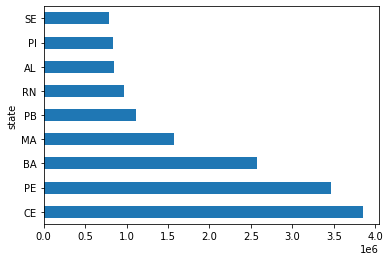

In [ ]:
nordeste = df_covid[df_covid['region'] == 'Nordeste']

nordeste.groupby('state')['last_available_deaths'].sum().sort_values(ascending=False).plot(kind='barh')

<AxesSubplot:ylabel='state'>

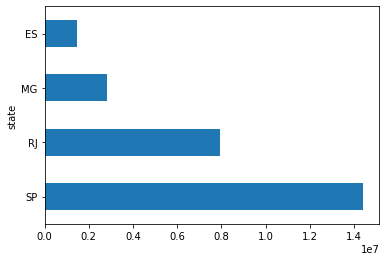

In [ ]:
sudeste = df_covid[df_covid['region'] == 'Sudeste']

sudeste.groupby('state')['last_available_deaths'].sum().sort_values(ascending=False).plot(kind='barh')

<AxesSubplot:ylabel='state'>

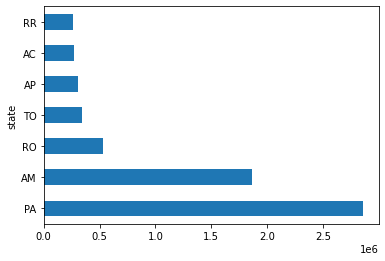

In [ ]:
norte = df_covid[df_covid['region'] == 'Norte']

norte.groupby('state')['last_available_deaths'].sum().sort_values(ascending=False).plot(kind='barh')

<AxesSubplot:ylabel='state'>

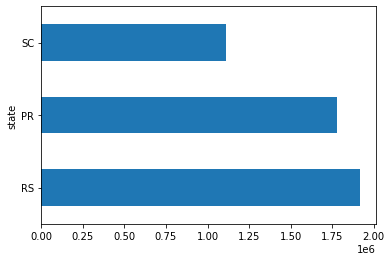

In [ ]:
sul = df_covid[df_covid['region'] == 'Sul']

sul.groupby('state')['last_available_deaths'].sum().sort_values(ascending=False).plot(kind='barh')

<AxesSubplot:ylabel='state'>

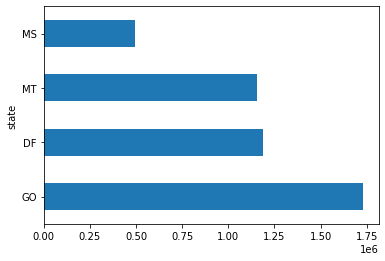

In [ ]:
centro_oeste = df_covid[df_covid['region'] == 'Centro Oeste']

centro_oeste.groupby('state')['last_available_deaths'].sum().sort_values(ascending=False).plot(kind='barh')

### Renomeação das colunas para pt-br

In [ ]:
df_covid.rename(columns={'last_available_confirmed' : 'confirmed', 'last_available_confirmed_per_100k_inhabitants' : 'incidence',
                    'estimated_population_2019' : 'population','last_available_deaths' : 'deaths',
                    'last_available_death_rate' : 'death_rate', 'order_for_place' : 'day'}, inplace = True)

/opt/venv/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


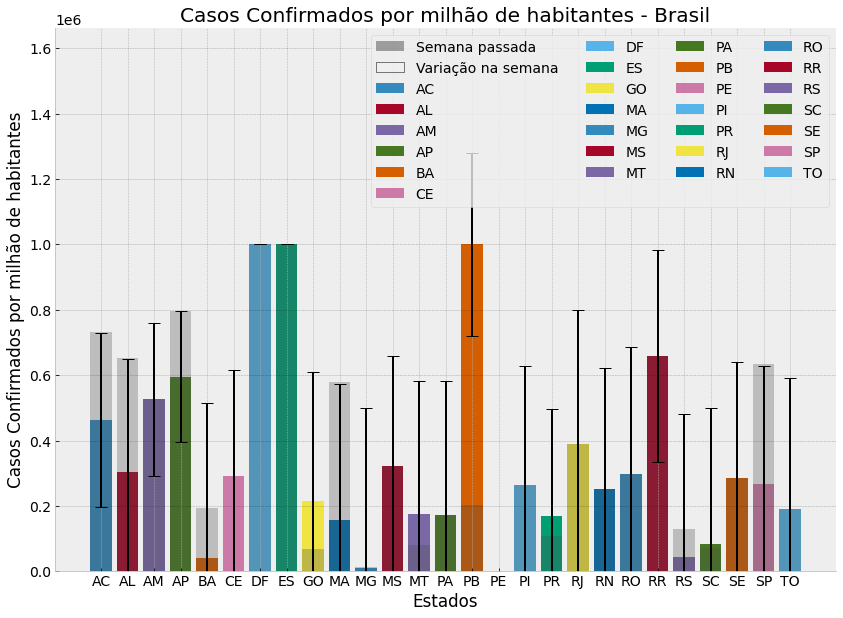

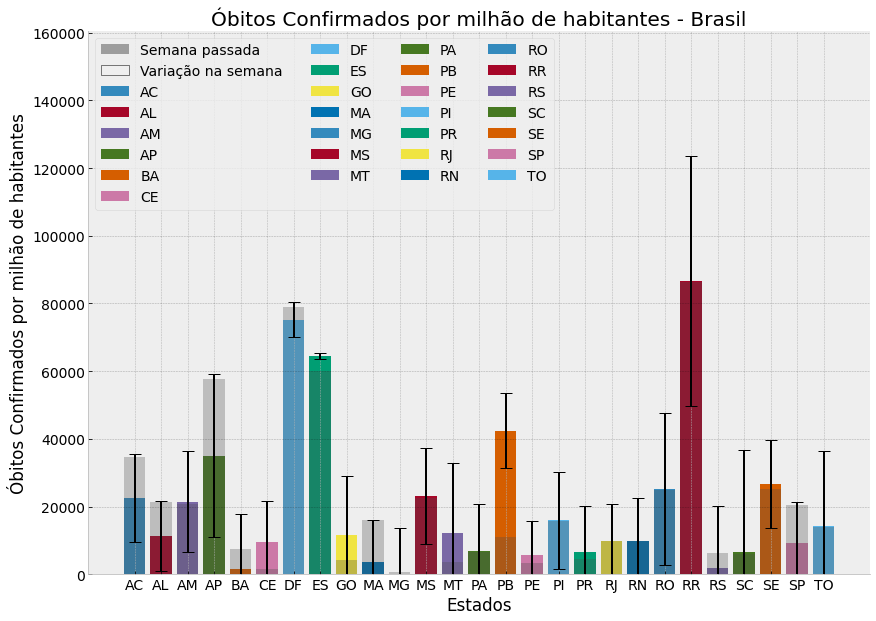

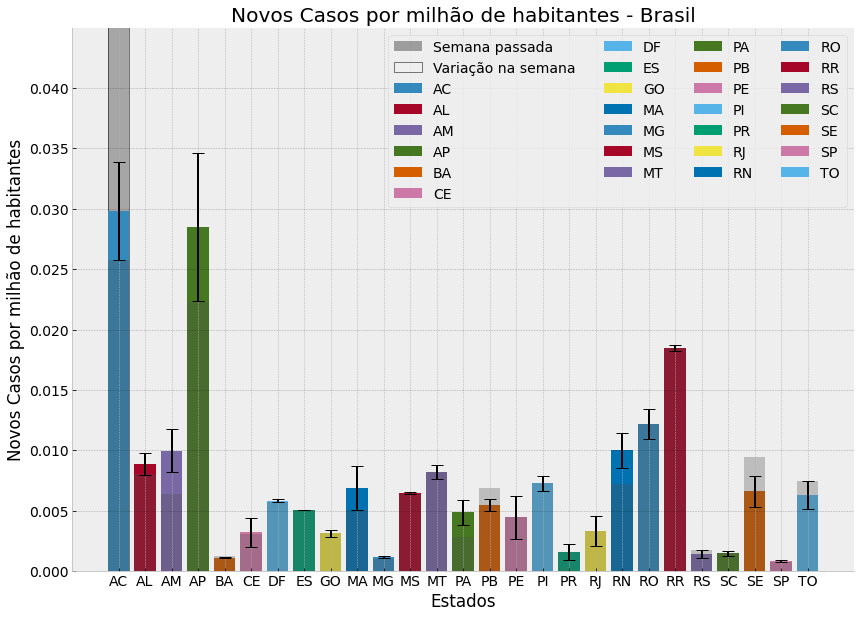

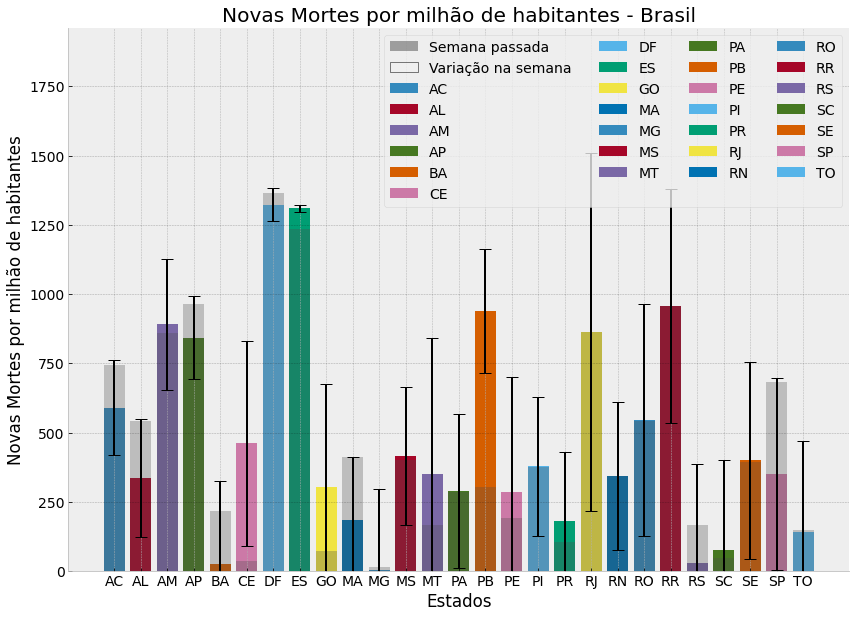

In [ ]:
plt.style.use('bmh')

label = ["Estado", "Regiao", "População", "Último Dado", "Data", "Dia", "Casos Confirmados",
         "Óbitos Confirmados", "Novos Casos", "Novas Mortes", "Incidência de Casos", "Mortalidade"]

for f in range(6, 10) :  
    plt.rc('font', size=14)
    plt.rcParams['figure.figsize'] = [14, 10]

    plt.gca().spines["top"].set_visible(False)    
    plt.gca().spines["right"].set_visible(False)
    plt.gca().get_xaxis().tick_bottom()    
    plt.gca().get_yaxis().tick_left()
    plt.grid(True, axis = 'y', linestyle = "dashed", lw = 0.5, color = "black", alpha = 0.3)

    estados = list(df_covid.loc[df_covid['is_last'],
                                  ['state']
                                 ].sort_values('state', ascending = True)['state'].unique())

    y_max = 0
    y_pmax = [5000, 1000, 1000, 200]
        
    plt.bar(estados[0], 1, label = 'Semana passada', color = (.3, .3, .3, .5))
    plt.bar(estados[0], 1, label = 'Variação na semana', color = (1, 1, 1, 0.1), edgecolor = 'black')
    
    for e in range(27) :      
        pop = max(df_covid.loc[(df_covid['state'] == estados[e]) & (df_covid['is_last']), 
                                 ['population']].loc[:, 'population'])
        
        y = np.median(df_covid.loc[(df_covid['state'] == estados[e]), 
                                   :].sort_values('day', ascending = True).iloc[:-1, f].tail(7))
        
        y_pop = (10 ** 6) * y / pop
        y_pop_std = (10 ** 6) * np.std(df_covid.loc[(df_covid['state'] == estados[e]),
                                                   :].sort_values('day', ascending = True).iloc[:-1, f].tail(7)) / pop        
        
        y_last = np.median(df_covid.loc[(df_covid['state'] == estados[e]), 
                                   :].sort_values('day', ascending = True).iloc[:-8, f].tail(14))
        
        y_pop_last = (10 ** 6) * y_last / pop
        y_pop_last_std = (10 ** 6) * np.std(df_covid.loc[(df_covid['state'] == estados[e]), 
                                                    :].sort_values('day', ascending = True).iloc[:-8, f].tail(14)) / pop
        
        if (y_pop + y_pop_std) > y_max : y_max = (y_pop + y_pop_std)
        #print(y_pop_std)
        
        ratio = y_pop / y_max
        
        if ratio < .0625 :
            plt.bar(estados[e], y_pop, yerr = y_pop_std, label = estados[e],  align='center', capsize = 6)
        elif (ratio >= .0625) & (ratio <= .125) :   
            plt.bar(estados[e], y_pop, yerr = y_pop_std, label = estados[e],  align='center', capsize = 6)
        elif (ratio >= .125) & (ratio <= .25) :
            plt.bar(estados[e], y_pop, yerr = y_pop_std, label = estados[e],  align='center', capsize = 6)
        elif (ratio >= .25) & (ratio <= .5) :
            plt.bar(estados[e], y_pop, yerr = y_pop_std, label = estados[e],  align='center', capsize = 6)
        elif (ratio >= .5) & (ratio <= .75) :
             plt.bar(estados[e], y_pop, yerr = y_pop_std, label = estados[e], align='center', capsize = 6)
        else  :
            plt.bar(estados[e], y_pop, yerr = y_pop_std, label = estados[e], align='center', capsize = 6)
        
        plt.bar(estados[e], y_pop_last, color = (.3, .3, .3, .3))
        
    plt.xlabel('Estados')       
    plt.ylim(0, y_max * 1.3)         
    plt.title(label[f] + " por milhão de habitantes - Brasil")
    plt.legend(ncol = 4)
    plt.ylabel(label[f] + " por milhão de habitantes")
    # plt.savefig('graficos/' + label[f] + " 1M.png")
    plt.show()

## Porcentagem de casos de mortalidade por casos confirmados de cada estados do Brasil

posx and posy should be finite values
posx and posy should be finite values


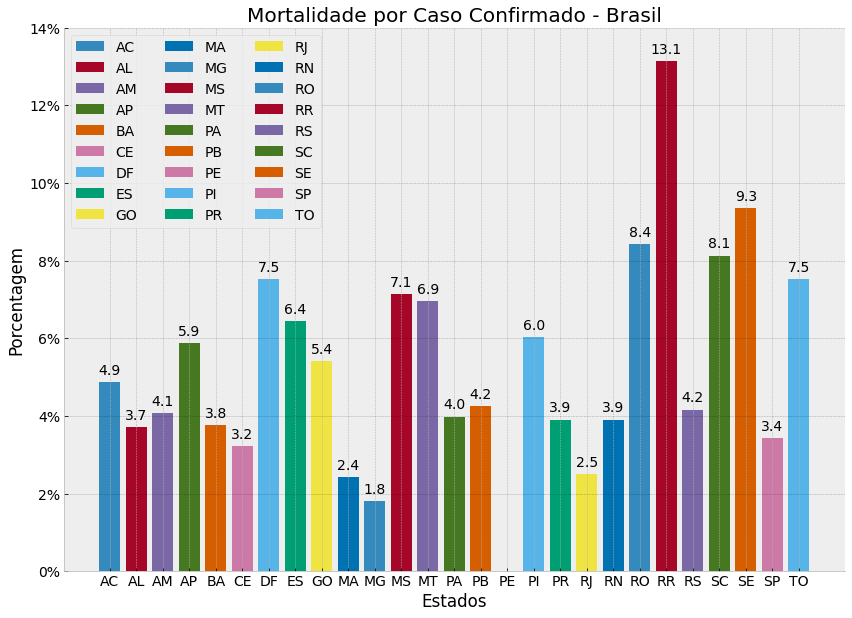

In [ ]:
plt.rc('font', size = 14)
plt.rcParams['figure.figsize'] = [14, 10]

plt.gca().spines["top"].set_visible(False)    
plt.gca().spines["right"].set_visible(False)
plt.gca().get_xaxis().tick_bottom()    
plt.gca().get_yaxis().tick_left()
plt.grid(True, axis = 'y', linestyle = "dashed", lw = 0.5, color = "black", alpha = 0.3)


estados = list(df_covid.loc[df_covid['is_last'],
                              ['state']
                             ].sort_values('state', ascending = True)['state'].unique())

y_max = 1

for e in range(27) :      
    y = np.median(df_covid.loc[(df_covid['state'] == estados[e]), 
                               :].sort_values('day', ascending = True).iloc[:-1, 7].tail(7))
    
    yc = np.median(df_covid.loc[(df_covid['state'] == estados[e]), 
                               :].sort_values('day', ascending = True).iloc[:-1, 6].tail(7))

    ymor = y / yc

    ratio = ymor / 0.15

    if ratio < .0625 :
        plt.bar(estados[e], ymor, label = estados[e])
    elif (ratio >= .0625) & (ratio <= .125) :   
        plt.bar(estados[e], ymor, label = estados[e])
    elif (ratio >= .125) & (ratio <= .25) :
        plt.bar(estados[e], ymor, label = estados[e])
    elif (ratio >= .25) & (ratio <= .5) :
        plt.bar(estados[e], ymor, label = estados[e])
    elif (ratio >= .5) & (ratio <= .75) :
         plt.bar(estados[e], ymor, label = estados[e])
    else  :
        plt.bar(estados[e], ymor, label = estados[e])
    
    if ymor != 0 :   
        plt.text(estados[e], ymor + .003, str(round(ymor * 100, 1)), color = 'black', 
                 fontsize = 14, horizontalalignment = 'center', verticalalignment = 'center')
    
plt.yticks(np.arange(0, .15, .02), 
           [str(x) + "%" for x in np.arange(0, 15, 2)], fontsize = 14)        
        
plt.xlabel('Estados')       
plt.ylim(0, 0.14)         
plt.title("Mortalidade por Caso Confirmado - Brasil")
plt.legend(ncol = 3)
plt.ylabel("Porcentagem")
# plt.savefig("graficos/ Mortalidade.png")
plt.show()

In [ ]:
df_estados = df_covid.groupby(['city', 'date', 'state'])['new_confirmed','new_deaths'].sum().reset_index()
df_estados

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,city,date,state,new_confirmed,new_deaths
0,Abadia de Goiás,2020-05-21,GO,6,0
1,Abadia de Goiás,2020-05-22,GO,-1,0
2,Abadia de Goiás,2020-05-23,GO,0,0
3,Abadia de Goiás,2020-05-24,GO,0,0
4,Abadia de Goiás,2020-05-25,GO,1,0
...,...,...,...,...,...
1374363,Óleo,2021-01-07,SP,0,0
1374364,Óleo,2021-01-08,SP,0,0
1374365,Óleo,2021-01-09,SP,0,0
1374366,Óleo,2021-01-10,SP,0,0


In [ ]:
df_estados.city.value_counts()

Importados/Indefinidos    5286
Bom Jesus                 1252
São Domingos              1148
Santa Luzia               1074
Bonito                    1000
                          ... 
Garruchos                  113
Novo Tiradentes            112
Pedras Altas               111
Estrela Velha              109
Coqueiro Baixo             101
Name: city, Length: 5298, dtype: int64

In [ ]:
#Agrupando por data,semana epidemiologica por ultimos confirmados e mortos
df_agrupado = df_covid.groupby(['epidemiological_week', 'date'])['new_confirmed', 'new_deaths'].sum().reset_index()
df_agrupado.sort_values(by='new_confirmed', ascending=False)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,epidemiological_week,date,new_confirmed,new_deaths
4,1,2021-01-07,158847,2720
278,47,2020-11-20,157574,2790
305,51,2020-12-17,138171,2127
304,51,2020-12-16,135779,1972
157,30,2020-07-22,132300,2592
...,...,...,...,...
14,10,2020-03-01,0,0
13,9,2020-02-29,0,0
11,9,2020-02-27,0,0
10,9,2020-02-26,0,0


### Plots das 3 semanas epidemiológicas com maiores registros de mortes

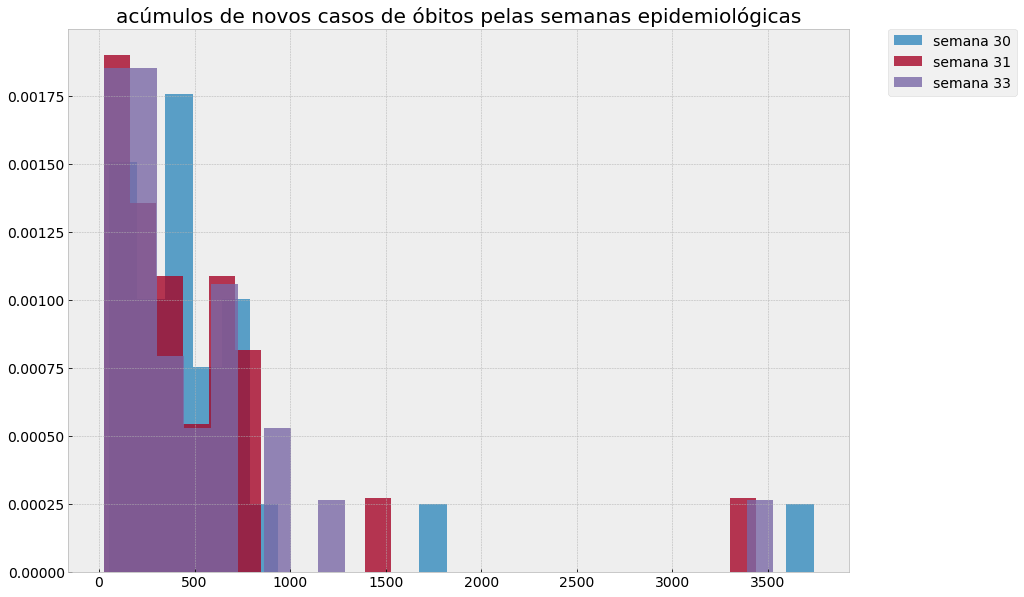

In [ ]:
plt.style.use('bmh')
plt.subplots()
df_covid[df_covid['epidemiological_week'] == 30].groupby('state')['new_deaths'].sum().hist(histtype="stepfilled",bins=25, alpha=0.8, density=True, label='semana 30')
df_covid[df_covid['epidemiological_week'] == 31].groupby('state')['new_deaths'].sum().hist(histtype="stepfilled",bins=25, alpha=0.8, density=True, label='semana 31')
df_covid[df_covid['epidemiological_week'] == 33].groupby('state')['new_deaths'].sum().hist(histtype="stepfilled",bins=25, alpha=0.8, density=True, label='semana 33')
plt.title('acúmulos de novos casos de óbitos pelas semanas epidemiológicas')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

### Gráfico demonstrativo de médias da evolução de novos casos de corona nos estados.

Text(0.5, 1.0, 'Média de novos casos por região')

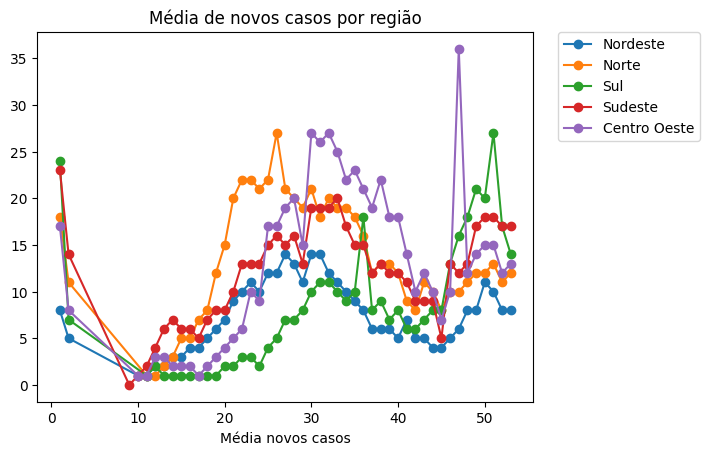

In [ ]:
plt.style.use('default')
df_covid[df_covid['region'] == 'Nordeste'].groupby('epidemiological_week')['new_confirmed'].mean().round().plot(marker='o',label='Nordeste')
df_covid[df_covid['region'] == 'Norte'].groupby('epidemiological_week')['new_confirmed'].mean().round().plot(marker='o',label='Norte')
df_covid[df_covid['region'] == 'Sul'].groupby('epidemiological_week')['new_confirmed'].mean().round().plot(marker='o',label='Sul')
df_covid[df_covid['region'] == 'Sudeste'].groupby('epidemiological_week')['new_confirmed'].mean().round().plot(marker='o',label='Sudeste')
df_covid[df_covid['region'] == 'Centro Oeste'].groupby('epidemiological_week')['new_confirmed'].mean().round().plot(marker='o',label='Centro Oeste')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Média novos casos')
plt.title('Média de novos casos por região')

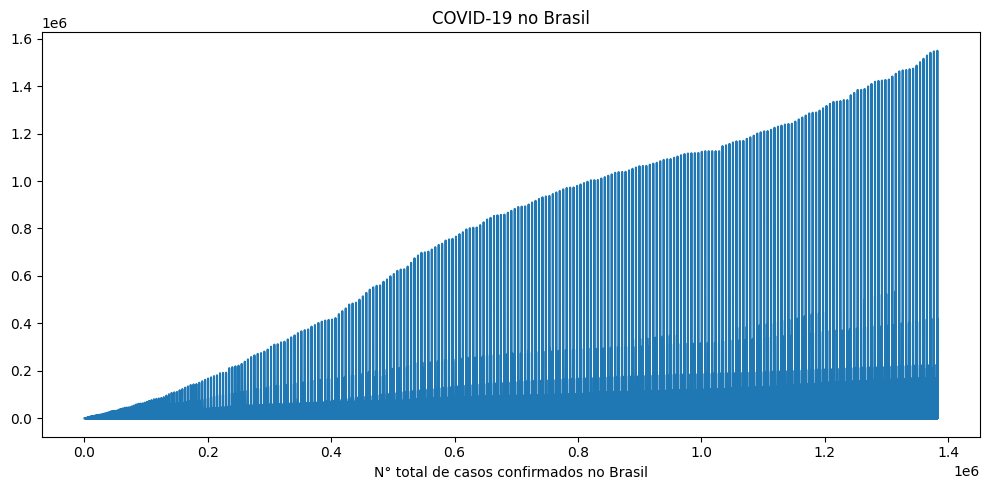

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))

ax.plot('confirmed', data = df_covid)
ax.set_title('COVID-19 no Brasil')
ax.set_xlabel('N° total de casos confirmados no Brasil')
plt.tight_layout()

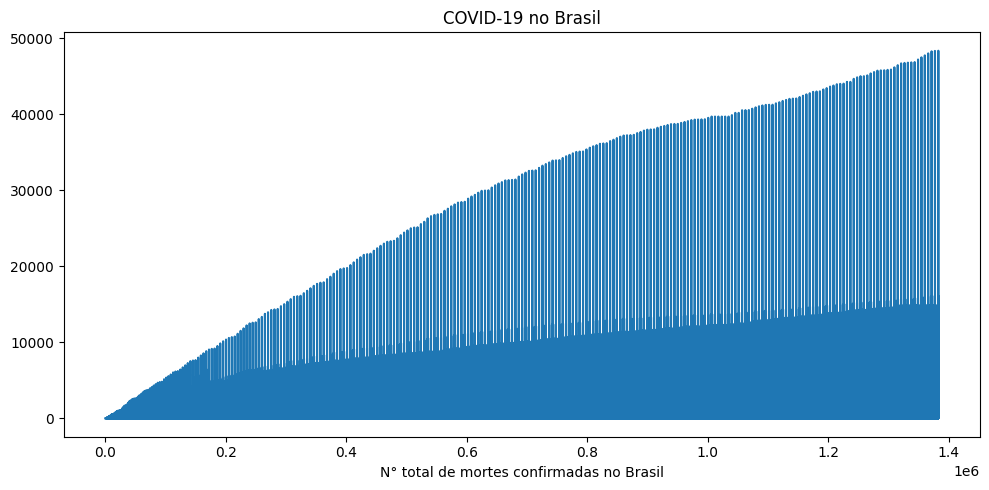

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))

ax.plot('deaths', data = df_covid)
ax.set_title('COVID-19 no Brasil')
ax.set_xlabel('N° total de mortes confirmadas no Brasil')
plt.tight_layout()

## Importa dados sobre temperatura e umidade do Inmet

In [ ]:
#Importar Dados
!mkdir /home/jovyan/work/weter
!wget https://portal.inmet.gov.br/uploads/dadoshistoricos/2020.zip
!unzip /home/jovyan/work/2020.zip
!mv *.CSV weter/
!rm 2020.zip


mkdir: cannot create directory ‘/home/jovyan/work/weter’: File exists
--2021-01-12 13:11:15--  https://portal.inmet.gov.br/uploads/dadoshistoricos/2020.zip
Resolving portal.inmet.gov.br (portal.inmet.gov.br)... 200.130.106.20
Connecting to portal.inmet.gov.br (portal.inmet.gov.br)|200.130.106.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 103653055 (99M) [application/zip]
Saving to: ‘2020.zip’

2020.zip              3%[                    ]   3.23M  3.47MB/s               ^C
Archive:  /home/jovyan/work/2020.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /home/jovyan/work/2020.zip or
        /home/jovyan/work/2020.zip.zip, and cannot find /home/jovyan/work/2020.zip.ZIP, period.
mv: cannot stat '*.CSV':

# TRATAMENTO DOS DADOS

## Tratamentos dos dados relativos ao clima e umidade

In [ ]:
#Unificar os dados de cada cidade por estados.
def import_date_state(state):
    all_files = glob.glob(state)
    li = []
    for filename in all_files:
        df = pd.read_csv(filename, skiprows=8, error_bad_lines=False, sep=';',encoding='latin-1')
        li.append(df)
    weter_state = pd.concat(li, axis=0, ignore_index=True)
    
    weter_state = weter_state.astype(str)
    weter_state = weter_state.applymap(lambda x: x.replace(',', '.'))
    weter_state[['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)','PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)','PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)','RADIACAO GLOBAL (Kj/m²)','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','TEMPERATURA DO PONTO DE ORVALHO (°C)','TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)','TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)','TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)','TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)','VENTO, DIREÇÃO HORARIA (gr) (° (gr))','VENTO, RAJADA MAXIMA (m/s)','VENTO, VELOCIDADE HORARIA (m/s)','UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)','UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)','UMIDADE RELATIVA DO AR, HORARIA (%)']] = weter_state[['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)','PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)','PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)','RADIACAO GLOBAL (Kj/m²)','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','TEMPERATURA DO PONTO DE ORVALHO (°C)','TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)','TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)','TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)','TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)','VENTO, DIREÇÃO HORARIA (gr) (° (gr))','VENTO, RAJADA MAXIMA (m/s)','VENTO, VELOCIDADE HORARIA (m/s)','UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)','UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)','UMIDADE RELATIVA DO AR, HORARIA (%)']].astype(float)
    
    return weter_state

In [ ]:
#Formatação inicial dos dados. Str para Float
def remove_commas(weter_state):
    weter_state = weter_state.astype(str)
    weter_state = weter_state.applymap(lambda x: x.replace(',', '.'))
    weter_state[['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)','PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)','PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)','RADIACAO GLOBAL (Kj/m²)','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','TEMPERATURA DO PONTO DE ORVALHO (°C)','TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)','TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)','TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)','TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)','VENTO, DIREÇÃO HORARIA (gr) (° (gr))','VENTO, RAJADA MAXIMA (m/s)','VENTO, VELOCIDADE HORARIA (m/s)','UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)','UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)','UMIDADE RELATIVA DO AR, HORARIA (%)']] = weter_state[['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)','PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)','PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)','RADIACAO GLOBAL (Kj/m²)','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','TEMPERATURA DO PONTO DE ORVALHO (°C)','TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)','TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)','TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)','TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)','VENTO, DIREÇÃO HORARIA (gr) (° (gr))','VENTO, RAJADA MAXIMA (m/s)','VENTO, VELOCIDADE HORARIA (m/s)','UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)','UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)','UMIDADE RELATIVA DO AR, HORARIA (%)']].astype(float)
    return weter_state

In [ ]:
#Agrupa dados do estado por data. Object para Data.
def data_byDay(weter_state):
    weter_state = weter_state.groupby('Data').mean()
    weter_state = weter_state.reset_index()
    weter_state['Data'] = pd.to_datetime(weter_state['Data'])
    weter_state['Data'] = weter_state.Data.dt.to_period("D")
    return weter_state

In [ ]:
# Arquivos para cidades especííficas:
fortaleza = 'weter/INMET_NE_CE_A305_FORTALEZA_01-01-2020_A_30-09-2020.CSV'
SaoPaulo_Mirante = 'weter/INMET_SE_SP_A701_SAO PAULO - MIRANTE_01-01-2020_A_30-09-2020.CSV'
SaoPaulo_Interlagos = 'weter/INMET_SE_SP_A771_SAO PAULO - INTERLAGOS_01-01-2020_A_30-09-2020.CSV'
Porto_Alegre = 'weter/INMET_S_RS_A801_PORTO ALEGRE_01-01-2020_A_30-09-2020.CSV'

#Arquivos para estados
DF = 'weter/INMET_CO_DF*.CSV'
GO = 'weter/INMET_CO_GO*.CSV'
MS = 'weter/INMET_CO_MS*.CSV'
MT = 'weter/INMET_CO_MT*.CSV'
AC = 'weter/INMET_N_AC*.CSV'
AM = 'weter/INMET_N_AM*.CSV'
AP = 'weter/INMET_N_AP*.CSV'
AL = 'weter/INMET_NE_AL*.CSV'
BA = 'weter/INMET_NE_BA*.CSV'
CE = 'weter/INMET_NE_CE*.CSV'
MA = 'weter/INMET_NE_MA*.CSV'
PB = 'weter/INMET_NE_PB*.CSV'
PE = 'weter/INMET_NE_PE*.CSV'
PI = 'weter/INMET_NE_PI*.CSV'
RN = 'weter/INMET_NE_RN*.CSV'
SE = 'weter/INMET_NE_SE*.CSV'
PA = 'weter/INMET_N_PA*.CSV'
RO = 'weter/INMET_N_RO*.CSV'
RR = 'weter/INMET_N_RR*.CSV'
TO = 'weter/INMET_N_TO*.CSV'
ES = 'weter/INMET_SE_ES*.CSV'
MG = 'weter/INMET_SE_MG*.CSV'
RJ = 'weter/INMET_SE_RJ*.CSV'
SP = 'weter/INMET_SE_SP*.CSV'
PR = 'weter/INMET_S_PR*.CSV'
RS = 'weter/INMET_S_RS*.CSV'
SC = 'weter/INMET_S_SC*.CSV'

states = [DF,GO,MS,MT,AC,AM,AP,AL,BA,CE,MA,PB,PE,PI,RN,SE,PA,RO,RR,TO,ES,MG,RJ,SP,PR,RS,SC]

In [ ]:
#Estados Específicos
weter_Acre = data_byDay(import_date_state(AC))
weter_Alagoas = data_byDay(import_date_state(AL))
weter_Amapa = data_byDay(import_date_state(AP))
weter_Amazonas = data_byDay(import_date_state(AM))
weter_Bahia = data_byDay(import_date_state(BA))
weter_Ceara = data_byDay(import_date_state(CE))
weter_DistritoFederal = data_byDay(import_date_state(DF))
weter_EspiritoSanto = data_byDay(import_date_state(ES))
weter_Goiais = data_byDay(import_date_state(GO))
weter_Maranhão = data_byDay(import_date_state(MA))
weter_MatoGrosso = data_byDay(import_date_state(MT))
weter_MatoGossoSul = data_byDay(import_date_state(MS))
weter_MinasGerais = data_byDay(import_date_state(MG))
weter_Para = data_byDay(import_date_state(PA))
weter_Paraiba = data_byDay(import_date_state(PB))
weter_Parana = data_byDay(import_date_state(PR))
weter_Pernambuco = data_byDay(import_date_state(PE))
weter_Piaui = data_byDay(import_date_state(PI))
weter_RiodeJaneiro = data_byDay(import_date_state(RJ))
weter_RioGrandedoNorte = data_byDay(import_date_state(RN))
weter_RioGrandeSul = data_byDay(import_date_state(RS))
weter_Rondonia = data_byDay(import_date_state(RO))
weter_Roraima = data_byDay(import_date_state(RR))
weter_SantaCatarina = data_byDay(import_date_state(SC))
weter_SaoPaulo = data_byDay(import_date_state(SP))
weter_Sergipe = data_byDay(import_date_state(SE))
weter_Tocantins = data_byDay(import_date_state(TO))

ValueError: No objects to concatenate

In [ ]:
#concatena todos os estados do BR
df_inmet = pd.concat([weter_Acre, weter_Alagoas, weter_Amapa, weter_Amazonas, weter_Bahia, 
            weter_Ceara, weter_DistritoFederal, weter_EspiritoSanto, weter_Goiais, 
            weter_Maranhão, weter_MatoGrosso, weter_MatoGossoSul, weter_MinasGerais,
            weter_Para, weter_Paraiba, weter_Parana, weter_Pernambuco, weter_Piaui,
            weter_RiodeJaneiro, weter_RioGrandedoNorte, weter_RioGrandeSul, weter_Rondonia,
            weter_Roraima, weter_SantaCatarina, weter_SaoPaulo, weter_Sergipe, weter_Tocantins])

df_inmet

# weter_all

,Data,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)"
0,2020-01-01,0.843056,987.917361,988.229861,987.562500,577.865000,25.202083,23.409722,25.601389,24.814583,23.735417,23.083333,91.881944,88.500000,90.319444,160.266667,2.855556,0.817361
1,2020-01-02,1.451389,989.586806,989.925694,989.165972,617.320588,24.213889,22.318750,24.563194,23.865278,22.640278,21.988194,91.416667,88.243056,89.784722,157.150000,3.276923,1.047917
2,2020-01-03,0.287500,991.147222,991.461972,990.700704,1174.360417,25.537500,22.458333,26.118310,24.931690,22.979577,21.971831,87.683099,81.887324,84.736111,233.233333,2.711972,0.853472
3,2020-01-04,1.370833,990.450694,990.845139,990.110417,708.164706,25.336111,23.172222,25.886806,24.889583,23.648611,22.874306,90.736111,86.402778,88.611111,224.275000,3.382639,0.990278
4,2020-01-05,0.088889,988.227778,988.622222,987.911806,1073.458824,26.209028,22.836806,26.699306,25.667361,23.343750,22.427083,85.951389,81.243056,83.368056,203.883333,3.441667,1.200694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2020-12-27,0.088031,977.603475,977.883784,977.267181,1250.833333,25.123166,21.935458,25.778764,24.463320,22.488755,21.353012,86.289157,79.489960,83.215139,177.344828,3.274783,1.046552
362,2020-12-28,0.034510,978.205882,978.486614,977.932677,1564.811446,27.138039,21.332400,27.761024,26.429921,22.048996,20.668675,77.152610,70.381526,73.668000,153.806167,3.599561,1.363596
363,2020-12-29,0.112782,977.359023,977.597736,977.069811,1733.797714,28.110902,20.677567,28.873208,27.317736,21.479924,19.909848,71.602273,63.590909,67.490494,154.326360,3.276695,1.259167
364,2020-12-30,0.045775,977.818662,978.070775,977.516549,1617.909945,28.017606,20.964184,28.815141,27.208099,21.826148,20.186572,73.321555,64.597173,68.627660,166.460938,3.238431,1.144922


In [ ]:
weter_Acre['Estado'] = 'AC' 
weter_Alagoas['Estado'] = 'AL'
weter_Amapa['Estado'] = 'AP'
weter_Amazonas['Estado'] = 'AM'
weter_Bahia['Estado'] = 'BA'
weter_Ceara['Estado'] = 'CE'
weter_DistritoFederal['Estado'] = 'DF'
weter_EspiritoSanto['Estado'] = 'ES'
weter_Goiais['Estado'] = 'GO'
weter_Maranhão['Estado'] = 'MA'
weter_MatoGrosso['Estado'] = 'MT'
weter_MatoGossoSul['Estado'] = 'MS'
weter_MinasGerais['Estado'] = 'MG'
weter_Para['Estado'] = 'PA'
weter_Paraiba['Estado'] = 'PB'
weter_Parana['Estado'] = 'PR'
weter_Pernambuco['Estado'] = 'PE'
weter_Piaui['Estado'] = 'PI'
weter_RiodeJaneiro['Estado'] = 'RJ'
weter_RioGrandedoNorte['Estado'] = 'RN'
weter_RioGrandeSul['Estado'] = 'RS'
weter_Rondonia['Estado'] = 'RO'
weter_Roraima['Estado'] = 'RR'
weter_SantaCatarina['Estado'] = 'SC'
weter_SaoPaulo['Estado'] = 'SP'
weter_Sergipe['Estado'] = 'SE'
weter_Tocantins['Estado'] = 'TO'

In [ ]:
weterList = [weter_Acre[['Estado','Data','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)']],
          weter_Alagoas[['Estado','Data','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)']],
          weter_Amapa[['Estado','Data','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)']],
          weter_Amazonas[['Estado','Data','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)']],
          weter_Bahia[['Estado','Data','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)']],
          weter_Ceara[['Estado','Data','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)']],
          weter_DistritoFederal[['Estado','Data','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)']],
          weter_EspiritoSanto[['Estado','Data','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)']],
          weter_Goiais[['Estado','Data','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)']],
          weter_Maranhão[['Estado','Data','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)']],
          weter_MatoGrosso[['Estado','Data','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)']],
          weter_MatoGossoSul[['Estado','Data','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)']],
          weter_MinasGerais[['Estado','Data','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)']],
          weter_Para[['Estado','Data','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)']],
          weter_Paraiba[['Estado','Data','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)']],
          weter_Parana[['Estado','Data','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)']],
          weter_Pernambuco[['Estado','Data','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)']],
          weter_Piaui[['Estado','Data','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)']],
          weter_RiodeJaneiro[['Estado','Data','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)']],
          weter_RioGrandedoNorte[['Estado','Data','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)']],
          weter_RioGrandeSul[['Estado','Data','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)']],
          weter_Rondonia[['Estado','Data','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)']],
          weter_Roraima[['Estado','Data','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)']],
          weter_SantaCatarina[['Estado','Data','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)']],
          weter_SaoPaulo[['Estado','Data','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)']],
          weter_Sergipe[['Estado','Data','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)']],
          weter_Tocantins[['Estado','Data','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)']]
        ]

df_temps_humi = pd.concat(weterList)

df_temps_humi['Data']=df_temps_humi['Data'].astype(str)

df_temps_humi

,Estado,Data,"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)","UMIDADE RELATIVA DO AR, HORARIA (%)"
0,AC,2020-01-01,25.202083,90.319444
1,AC,2020-01-02,24.213889,89.784722
2,AC,2020-01-03,25.537500,84.736111
3,AC,2020-01-04,25.336111,88.611111
4,AC,2020-01-05,26.209028,83.368056
...,...,...,...,...
361,TO,2020-12-27,25.123166,83.215139
362,TO,2020-12-28,27.138039,73.668000
363,TO,2020-12-29,28.110902,67.490494
364,TO,2020-12-30,28.017606,68.627660


# Estudo dos Dados Brasil por MÊS

In [ ]:
df_temps_humi['Data']= df_temps_humi['Data'].astype(str)

df_br_clima = df_temps_humi.groupby(by=['Data','Estado'])[['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)']].mean()
df_br_clima = df_br_clima.reset_index()
df_br_clima

,Data,Estado,"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)","UMIDADE RELATIVA DO AR, HORARIA (%)"
0,2020-01-01,AC,25.202083,90.319444
1,2020-01-01,AL,26.807639,74.429577
2,2020-01-01,AM,26.415584,82.062500
3,2020-01-01,AP,26.129032,83.161290
4,2020-01-01,BA,25.130662,76.965616
...,...,...,...,...
9877,2020-12-31,RS,22.459567,72.443742
9878,2020-12-31,SC,22.769472,83.367220
9879,2020-12-31,SE,26.185000,65.941667
9880,2020-12-31,SP,22.345469,78.887960


In [ ]:
df_br_clima['Data'] = pd.DatetimeIndex(df_br_clima['Data']).month
df_br_clima = df_br_clima.groupby(by=['Data','Estado']).mean().reset_index()
df_br_clima

,Data,Estado,"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)","UMIDADE RELATIVA DO AR, HORARIA (%)"
0,1,AC,26.107751,84.142697
1,1,AL,28.069534,65.906375
2,1,AM,27.019963,80.345544
3,1,AP,25.976014,83.658345
4,1,BA,26.062065,72.119526
...,...,...,...,...
319,12,RS,22.488509,71.187013
320,12,SC,21.200330,79.770501
321,12,SE,26.292663,66.208759
322,12,SP,22.901119,75.901669


### Analises de NOVOS CASOS CONFIRMADOS por mês, de todos os estados do BR

In [ ]:
df_covid_casos = df_covid[['date','state','deaths','new_confirmed']]
df_covid_casos['date'] = pd.DatetimeIndex(df_covid_casos['date']).month

df_covid_casos = df_covid_casos.groupby(by=['date','state'])[['new_confirmed']].sum()
df_covid_casos = df_covid_casos.reset_index()
df_covid_casos



/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,date,state,new_confirmed
0,1,AC,3233
1,1,AL,6812
2,1,AM,27082
3,1,AP,5787
4,1,BA,39797
...,...,...,...
293,12,RS,255232
294,12,SC,256478
295,12,SE,44714
296,12,SP,441288


In [ ]:
df_br_merge = pd.merge(df_covid_casos, df_br_clima, left_on= ['date','state'], right_on= ['Data','Estado'] )
df_br_merge = df_br_merge[['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)','new_confirmed']]
df_br_merge = df_br_merge[df_br_merge['new_confirmed']>1500]
df_br_merge

,"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)","UMIDADE RELATIVA DO AR, HORARIA (%)",new_confirmed
0,26.107751,84.142697,3233
1,28.069534,65.906375,6812
2,27.019963,80.345544,27082
3,25.976014,83.658345,5787
4,26.062065,72.119526,39797
...,...,...,...
293,22.488509,71.187013,255232
294,21.200330,79.770501,256478
295,26.292663,66.208759,44714
296,22.901119,75.901669,441288


### Primeira Analise: Correlação entre Novos Casos Confirmados X Temperatura X Umidade

<AxesSubplot:>

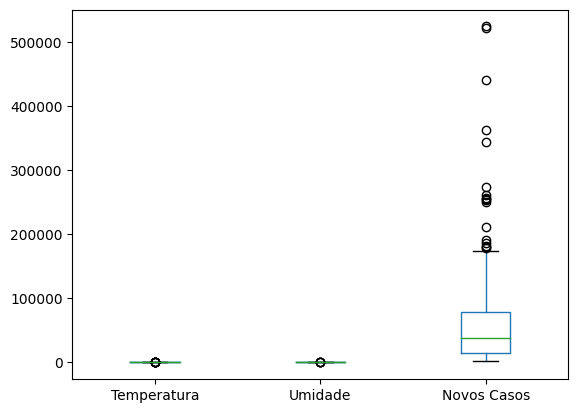

In [ ]:
df_br_merge.columns = ['Temperatura', 'Umidade','Novos Casos']
df_br_merge[['Temperatura', 'Umidade','Novos Casos']].plot.box()

<AxesSubplot:>

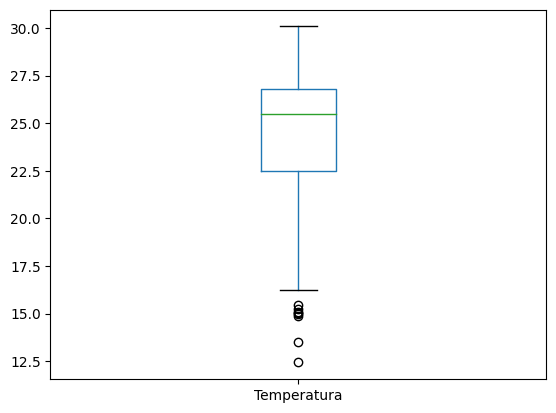

In [ ]:
df_br_merge[['Temperatura',]].plot.box()

<AxesSubplot:>

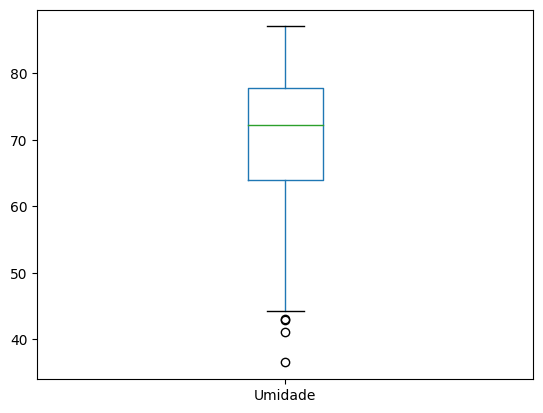

In [ ]:
df_br_merge[['Umidade',]].plot.box()

In [ ]:
df_br_z = (df_br_merge['Novos Casos'] - df_br_merge['Novos Casos'].mean())/df_br_merge['Novos Casos'].std()
df_br_z = df_br_z.sort_values()
df_br_z.tail(15)

167    1.568494
140    1.628296
186    1.692503
267    1.958521
269    2.487690
281    2.515251
293    2.542653
294    2.559037
242    2.618471
288    2.775812
134    3.701504
215    3.954070
296    4.989110
161    6.048395
188    6.077691
Name: Novos Casos, dtype: float64

<AxesSubplot:>

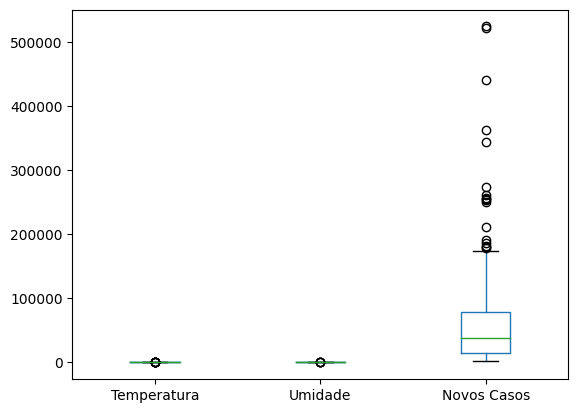

In [ ]:
df_br_merge[['Temperatura', 'Umidade','Novos Casos']].plot.box()

In [ ]:
df_br_merge = df_br_merge.drop([161,134,188,107,215,242,240,159,113,140,146,119,80,173,171])

In [ ]:
df_corr_pearson_br = df_br_merge.corr(method='pearson')
df_corr_pearson_br

,Temperatura,Umidade,Novos Casos
Temperatura,1.000000,-0.256059,-0.292983
Umidade,-0.256059,1.000000,-0.080608
Novos Casos,-0.292983,-0.080608,1.000000


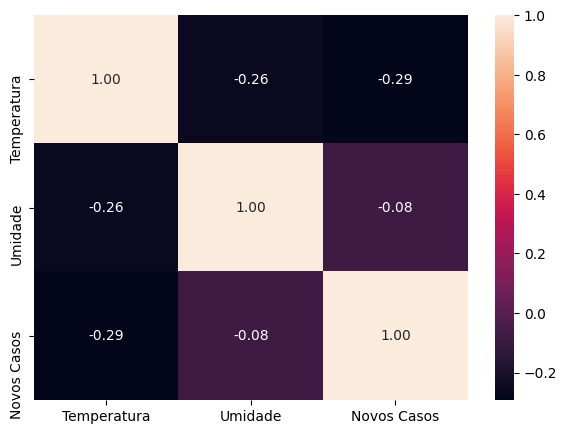

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
hm = sns.heatmap(df_corr_pearson_br, ax = ax, fmt = '.2f', annot=True)

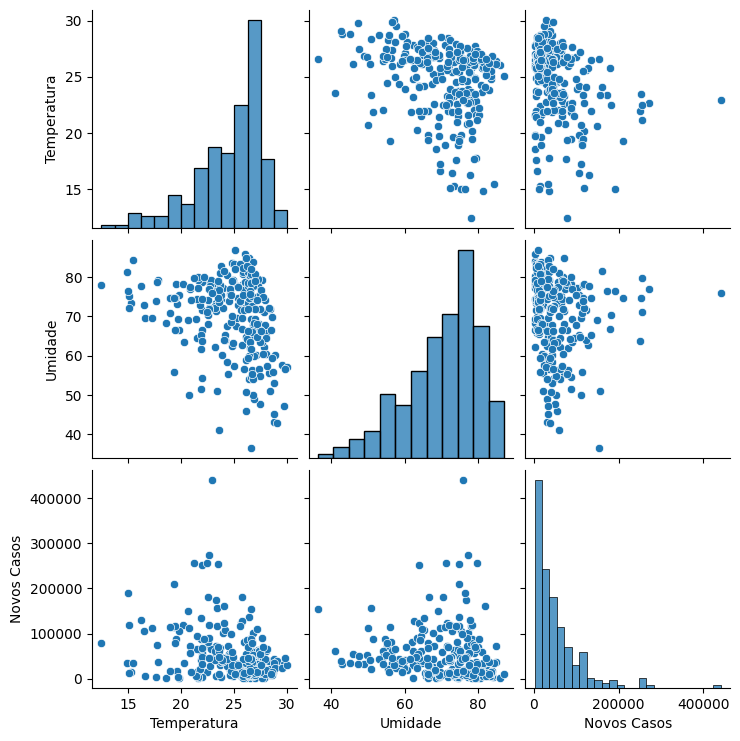

In [ ]:
pairs = sns.pairplot(df_br_merge)

In [ ]:
#Criar features e target 
target = df_br_merge.loc[:,'Novos Casos']
features = df_br_merge.loc[:, 'Temperatura':'Umidade']
#Estimar relação com OLS
result = OLS(target, features, hasconst=False).fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:            Novos Casos   R-squared (uncentered):                     nan
Model:                            OLS   Adj. R-squared (uncentered):                nan
Method:                 Least Squares   F-statistic:                                nan
Date:                Tue, 12 Jan 2021   Prob (F-statistic):                         nan
Time:                        12:22:04   Log-Likelihood:                             nan
No. Observations:                 247   AIC:                                        nan
Df Residuals:                     247   BIC:                                        nan
Df Model:                           0                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

<AxesSubplot:xlabel='Temperatura', ylabel='Novos Casos'>

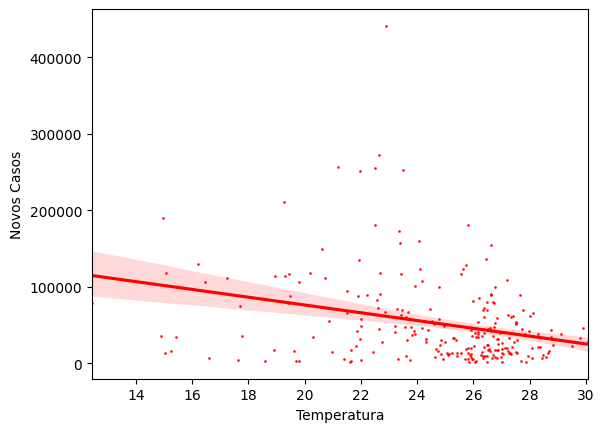

In [ ]:
sns.regplot(x='Temperatura', y='Novos Casos', data=df_br_merge,marker='o', color='red', scatter_kws={'s':1})

<AxesSubplot:xlabel='Umidade', ylabel='Novos Casos'>

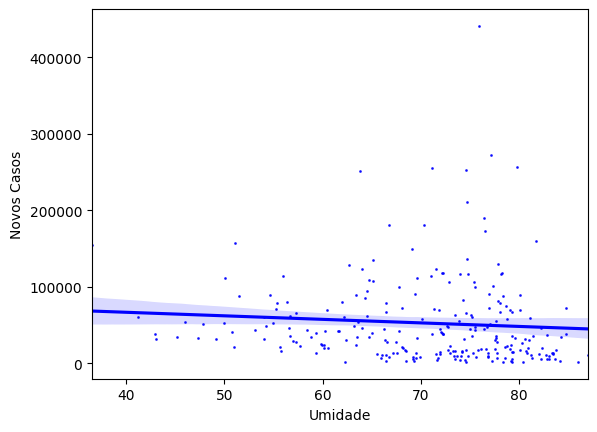

In [ ]:
sns.regplot(x='Umidade', y='Novos Casos', data=df_br_merge,marker='o', color='blue', scatter_kws={'s':1})

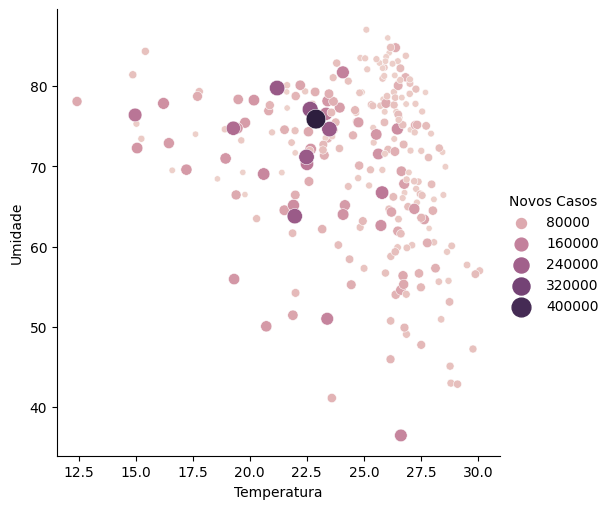

In [ ]:
sns.relplot(x='Temperatura', y='Umidade', hue='Novos Casos' , data=df_br_merge, size="Novos Casos", sizes=(20, 200))

# Dados do Estado de São Paulo 

In [ ]:
df_sp = df_covid[df_covid['state']=='SP']
df_sp['date'] = pd.DatetimeIndex(df_sp['date']).month
df_sp

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,state,city,date,day,is_last,epidemiological_week,population,confirmed,death_rate,deaths,new_confirmed,new_deaths,region
0,SP,São Paulo,2,1,False,9,12252023.0,1,0.0000,0,1,0,Sudeste
1,SP,NaN,2,1,False,9,45919049.0,1,0.0000,0,1,0,Sudeste
2,SP,São Paulo,2,2,False,9,12252023.0,1,0.0000,0,0,0,Sudeste
3,SP,NaN,2,2,False,9,45919049.0,1,0.0000,0,0,0,Sudeste
4,SP,São Paulo,2,3,False,9,12252023.0,1,0.0000,0,0,0,Sudeste
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1382437,SP,Álvares Florence,1,228,True,2,3679.0,112,0.0536,6,0,0,Sudeste
1382438,SP,Álvares Machado,1,259,True,2,24915.0,465,0.0323,15,0,0,Sudeste
1382439,SP,Álvaro de Carvalho,1,249,True,2,5227.0,54,0.0741,4,0,0,Sudeste
1382440,SP,Óleo,1,207,True,2,2496.0,6,0.0000,0,0,0,Sudeste


In [ ]:
df_sp_casos = df_sp.groupby(by='date')[['deaths','new_confirmed']].sum()
df_sp_casos = df_sp_casos.reset_index()
df_sp_casos

,date,deaths,new_confirmed
0,1,1045041,173690
1,2,0,4
2,3,1341,4674
3,4,56490,52718
4,5,295876,162000
5,6,674048,343364
6,7,1175732,521848
7,8,1660914,524076
8,9,1984866,362572
9,10,2337472,260998


Realizar observações em relação a quantidade de casos relatados por dia no gráfico date x novos confirmados acima. (sub-notificações, atrasos de pesquisa.)

Por exemplo: Dia 2020-11-06 à 2020-11-09 há 0 casos porém no dia 2020-11-10, 43030 casos

In [ ]:
weter_SaoPaulo['Data']= weter_SaoPaulo['Data'].astype(str)

df_sp_clima = weter_SaoPaulo.groupby(by='Data')[['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)']].mean()
df_sp_clima = df_sp_clima.reset_index()
df_sp_clima

,Data,"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)","UMIDADE RELATIVA DO AR, HORARIA (%)"
0,2020-01-01,24.978824,69.579356
1,2020-01-02,23.293427,80.800000
2,2020-01-03,21.643133,83.368664
3,2020-01-04,21.896137,79.032955
4,2020-01-05,21.839112,82.711340
...,...,...,...
361,2020-12-27,21.636215,82.036851
362,2020-12-28,21.881774,80.381113
363,2020-12-29,22.947695,78.983740
364,2020-12-30,23.436307,74.202922


In [ ]:
df_sp_clima['Data'] = pd.DatetimeIndex(df_sp_clima['Data']).month
df_sp_clima = df_sp_clima.groupby(by='Data').mean().reset_index()
df_sp_clima

,Data,"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)","UMIDADE RELATIVA DO AR, HORARIA (%)"
0,1,23.344848,76.559660
1,2,22.311200,81.088489
2,3,21.992840,71.695024
3,4,20.294386,69.350667
4,5,17.218741,67.217208
5,6,18.479315,71.041167
6,7,17.932724,63.449496
7,8,17.853578,61.546177
8,9,22.286554,54.447287
9,10,22.411128,62.500654


In [ ]:
df_sp_merge = df_sp_casos.merge(df_sp_clima, left_on= 'date', right_on= 'Data')
df_sp_merge = df_sp_merge[['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)','new_confirmed']]
df_sp_merge = df_sp_merge.drop(0)
df_sp_merge

,"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)","UMIDADE RELATIVA DO AR, HORARIA (%)",new_confirmed
1,22.311200,81.088489,4
2,21.992840,71.695024,4674
3,20.294386,69.350667,52718
4,17.218741,67.217208,162000
5,18.479315,71.041167,343364
6,17.932724,63.449496,521848
7,17.853578,61.546177,524076
8,22.286554,54.447287,362572
9,22.411128,62.500654,260998
10,21.972972,63.809758,251052


In [ ]:
df_sp_merge.columns = ['Temperatura', 'Umidade','Novos Casos']


<AxesSubplot:>

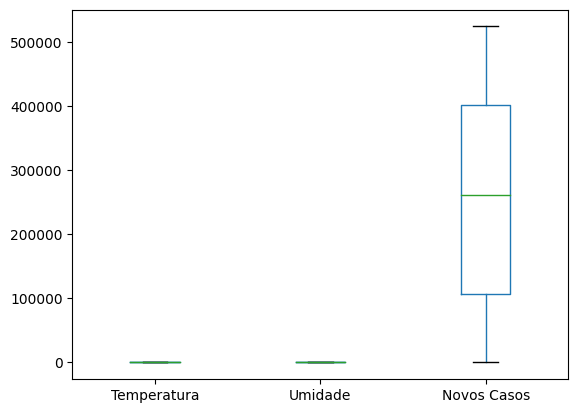

In [ ]:
df_sp_merge[['Temperatura', 'Umidade','Novos Casos']].plot.box()

(array([[11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 2.,  1.,  0.,  1.,  2.,  0.,  2.,  0.,  1.,  2.]]),
 array([4.000000e+00, 5.241120e+04, 1.048184e+05, 1.572256e+05,
        2.096328e+05, 2.620400e+05, 3.144472e+05, 3.668544e+05,
        4.192616e+05, 4.716688e+05, 5.240760e+05]),
 <a list of 3 BarContainer objects>)

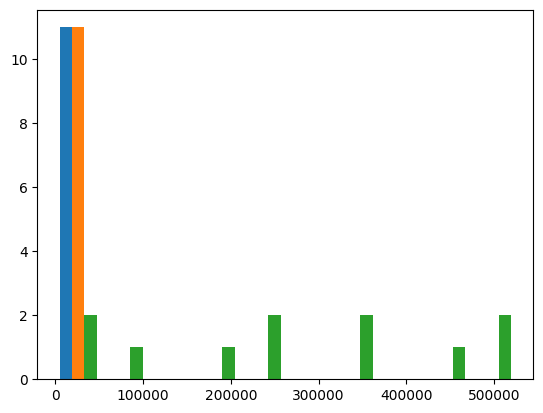

In [ ]:
plt.hist(df_sp_merge)

In [ ]:
df = (df_sp_merge['Novos Casos'] - df_sp_merge['Novos Casos'].mean())/df_sp_merge['Novos Casos'].std()
df = df.sort_values()
df.tail(10)

2    -1.351171
3    -1.102640
4    -0.537328
10   -0.076664
9    -0.025214
5     0.400863
8     0.500225
11    0.907421
6     1.324155
7     1.335681
Name: Novos Casos, dtype: float64

In [ ]:
#covariancia
df_covariancia = df_sp_merge.cov()
df_covariancia

,Temperatura,Umidade,Novos Casos
Temperatura,4.877260,3.229124,-1.421063e+05
Umidade,3.229124,54.969878,-7.082654e+05
Novos Casos,-142106.314254,-708265.380354,3.736973e+10


In [ ]:
df_corr_kendall = df_sp_merge.corr(method='kendall')
df_corr_kendall

,Temperatura,Umidade,Novos Casos
Temperatura,1.000000,0.236364,-0.163636
Umidade,0.236364,1.000000,-0.490909
Novos Casos,-0.163636,-0.490909,1.000000


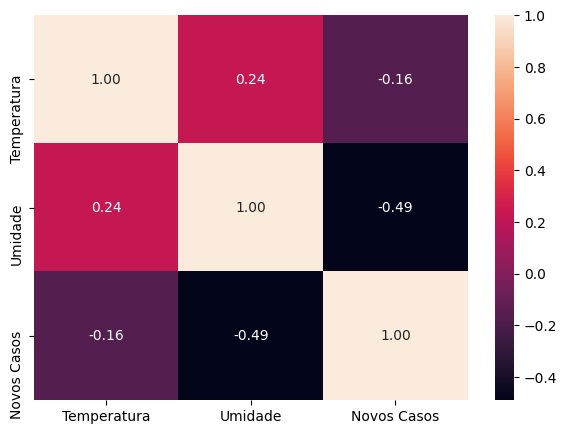

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
hm = sns.heatmap(df_corr_kendall, ax = ax, fmt = '.2f', annot=True)

In [ ]:
df_corr_spearman = df_sp_merge.corr(method='spearman')
df_corr_spearman

,Temperatura,Umidade,Novos Casos
Temperatura,1.000000,0.300000,-0.190909
Umidade,0.300000,1.000000,-0.572727
Novos Casos,-0.190909,-0.572727,1.000000


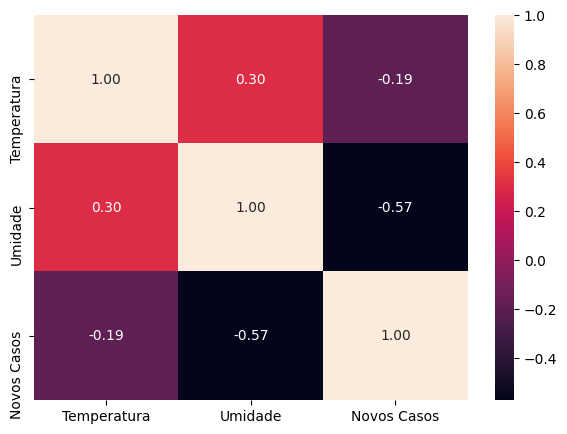

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
hm = sns.heatmap(df_corr_spearman, ax = ax, fmt = '.2f', annot=True)

In [ ]:
df_corr_pearson = df_sp_merge.corr(method='pearson')
df_corr_pearson

,Temperatura,Umidade,Novos Casos
Temperatura,1.000000,0.197212,-0.332863
Umidade,0.197212,1.000000,-0.494167
Novos Casos,-0.332863,-0.494167,1.000000


Nestes resultados, a correlação de Pearson entre a temperatura é −0,790 e os novos casos é −0.411. A relação entre estas variáveis é negativa, o que indica que, conforme a temperatura e a umidade aumentam, 


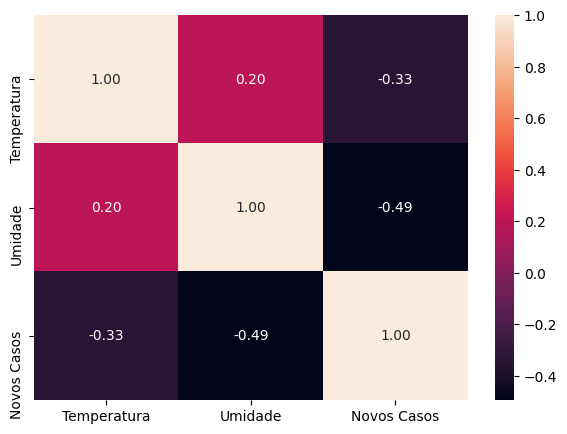

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
hm = sns.heatmap(df_corr_pearson, ax = ax, fmt = '.2f', annot=True)

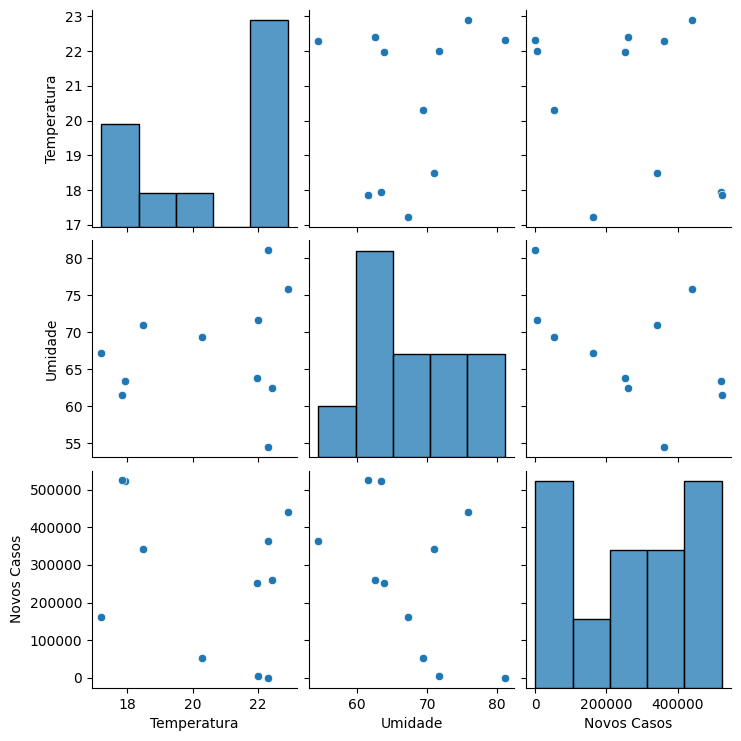

In [ ]:
pairs = sns.pairplot(df_sp_merge)

In [ ]:
#Criar features e target 
target = df_sp_merge.loc[:,'Novos Casos']
features = df_sp_merge.loc[:, 'Temperatura':'Umidade']
#Estimar relação com OLS
result = OLS(target, features, hasconst=False).fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:            Novos Casos   R-squared (uncentered):                   0.638
Model:                            OLS   Adj. R-squared (uncentered):              0.557
Method:                 Least Squares   F-statistic:                              7.922
Date:                Tue, 12 Jan 2021   Prob (F-statistic):                      0.0104
Time:                        12:22:09   Log-Likelihood:                         -149.58
No. Observations:                  11   AIC:                                      303.2
Df Residuals:                       9   BIC:                                      304.0
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [ ]:
# mostrando as previsões para o mesmo conjunto passado
result.predict(features)

1     271578.157478
2     275407.978034
3     251152.383310
4     205253.604766
5     221306.295971
6     219896.514296
7     220444.544690
8     296116.627489
9     290522.770918
10    282475.070790
11    285616.649833
dtype: float64

<AxesSubplot:xlabel='Temperatura', ylabel='Novos Casos'>

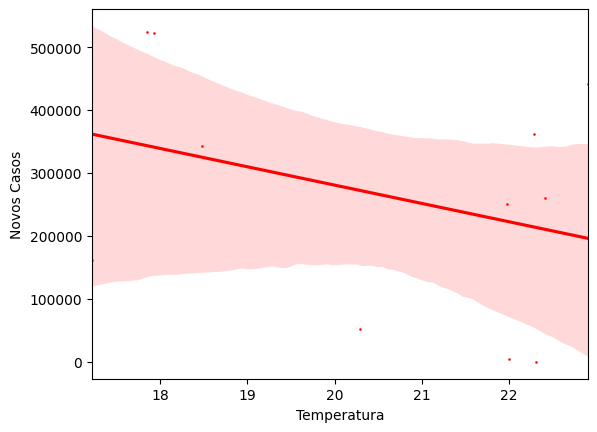

In [ ]:
sns.regplot(x=features.iloc[:,0], y=target, data=df_sp_merge,marker='o', color='red', scatter_kws={'s':1})

<AxesSubplot:xlabel='Umidade', ylabel='Novos Casos'>

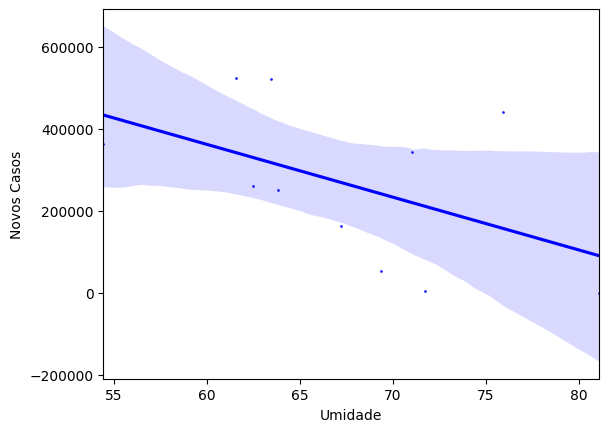

In [ ]:
sns.regplot(x=features.iloc[:,1], y=target, data=df_sp_merge,marker='o', color='blue', scatter_kws={'s':1})

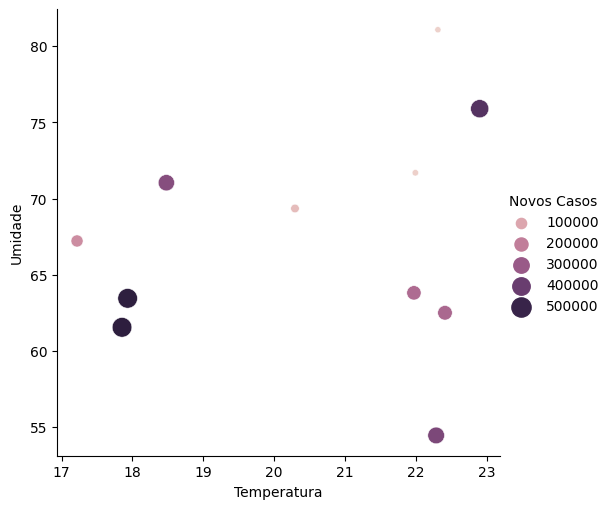

In [ ]:
sns.relplot(x='Temperatura', y='Umidade', hue='Novos Casos' , data=df_sp_merge, size="Novos Casos", sizes=(20, 200))

## **Verificação por média**

In [ ]:
df_sp_media = df_covid[df_covid['state']=='SP']
df_sp_media

,state,city,date,day,is_last,epidemiological_week,population,confirmed,death_rate,deaths,new_confirmed,new_deaths,region
0,SP,São Paulo,2020-02-25,1,False,9,12252023.0,1,0.0000,0,1,0,Sudeste
1,SP,NaN,2020-02-25,1,False,9,45919049.0,1,0.0000,0,1,0,Sudeste
2,SP,São Paulo,2020-02-26,2,False,9,12252023.0,1,0.0000,0,0,0,Sudeste
3,SP,NaN,2020-02-26,2,False,9,45919049.0,1,0.0000,0,0,0,Sudeste
4,SP,São Paulo,2020-02-27,3,False,9,12252023.0,1,0.0000,0,0,0,Sudeste
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1382437,SP,Álvares Florence,2021-01-11,228,True,2,3679.0,112,0.0536,6,0,0,Sudeste
1382438,SP,Álvares Machado,2021-01-11,259,True,2,24915.0,465,0.0323,15,0,0,Sudeste
1382439,SP,Álvaro de Carvalho,2021-01-11,249,True,2,5227.0,54,0.0741,4,0,0,Sudeste
1382440,SP,Óleo,2021-01-11,207,True,2,2496.0,6,0.0000,0,0,0,Sudeste


In [ ]:
df_sp_casos_media = df_sp_media.groupby(by='date')[['deaths','new_confirmed']].sum()
df_sp_casos_media = df_sp_casos_media.reset_index()
df_sp_casos_media['new_confirmed'] = df_sp_casos_media['new_confirmed'].astype(int)
df_sp_casos_media = df_sp_casos_media[df_sp_casos_media['new_confirmed']>1500]
df_sp_casos_media

,date,deaths,new_confirmed
35,2020-03-31,272,1644
42,2020-04-07,742,1632
43,2020-04-08,856,2052
44,2020-04-09,992,1544
50,2020-04-15,1556,3344
...,...,...,...
317,2021-01-07,95536,42680
318,2021-01-08,96058,27588
319,2021-01-09,96327,11561
320,2021-01-10,96702,22799


In [ ]:
weter_SaoPaulo['Data']= weter_SaoPaulo['Data'].astype(str)

df_sp_clima = weter_SaoPaulo.groupby(by='Data')[['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)']].mean()
df_sp_clima = df_sp_clima.reset_index()
df_sp_clima['diff_7days'] = df_sp_clima['Data'].astype('datetime64[ns]') + np.timedelta64(1, 'W')
df_sp_clima['diff_7days']= df_sp_clima['diff_7days'].astype(str)
df_sp_clima['diff_15days'] = df_sp_clima['Data'].astype('datetime64[ns]') + np.timedelta64(2, 'W')
df_sp_clima['diff_15days']= df_sp_clima['diff_15days'].astype(str)
df_sp_clima

,Data,"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)","UMIDADE RELATIVA DO AR, HORARIA (%)",diff_7days,diff_15days
0,2020-01-01,24.978824,69.579356,2020-01-08,2020-01-15
1,2020-01-02,23.293427,80.800000,2020-01-09,2020-01-16
2,2020-01-03,21.643133,83.368664,2020-01-10,2020-01-17
3,2020-01-04,21.896137,79.032955,2020-01-11,2020-01-18
4,2020-01-05,21.839112,82.711340,2020-01-12,2020-01-19
...,...,...,...,...,...
361,2020-12-27,21.636215,82.036851,2021-01-03,2021-01-10
362,2020-12-28,21.881774,80.381113,2021-01-04,2021-01-11
363,2020-12-29,22.947695,78.983740,2021-01-05,2021-01-12
364,2020-12-30,23.436307,74.202922,2021-01-06,2021-01-13


Selecionar através de right_on, quais dias quer utilizar, data normal, 7 ou 15 dias a frente.

In [ ]:
df_sp_merge_media = df_sp_casos_media.merge(df_sp_clima, left_on= 'date', right_on='diff_7days')
df_sp_merge_media = df_sp_merge_media[['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)','new_confirmed']]
df_sp_merge_media = df_sp_merge_media.drop(0)
df_sp_merge_media

,"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)","UMIDADE RELATIVA DO AR, HORARIA (%)",new_confirmed
1,22.543944,74.613861,1632
2,22.906424,71.571429,2052
3,23.644962,70.086570,1544
4,20.879194,76.950111,3344
5,18.862756,67.353458,2546
...,...,...,...
244,21.636215,82.036851,12594
245,21.881774,80.381113,4496
246,22.947695,78.983740,25762
247,23.436307,74.202922,14534


In [ ]:
df_sp_merge_media.columns = ['Temperatura', 'Umidade','Novos Casos']

<AxesSubplot:>

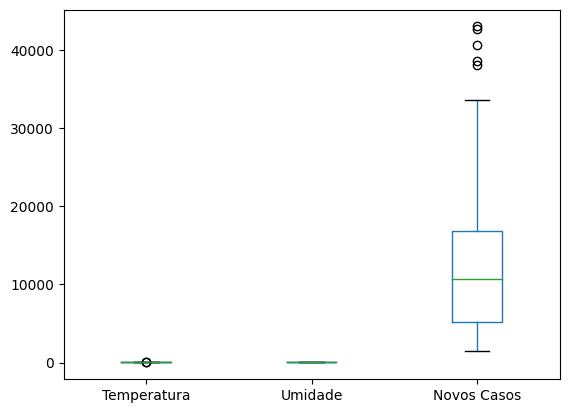

In [ ]:
df_sp_merge_media[['Temperatura', 'Umidade','Novos Casos']].plot.box()

In [ ]:
df = (df_sp_merge_media['Novos Casos'] - df_sp_merge_media['Novos Casos'].mean())/df_sp_merge_media['Novos Casos'].std()
df = df.sort_values()
df.tail(10)

106    2.194469
114    2.252814
241    2.376211
96     2.404325
93     2.525250
60     3.055301
115    3.112705
228    3.354792
248    3.598761
193    3.639932
Name: Novos Casos, dtype: float64

In [ ]:
df_sp_merge_media_teste = df_sp_merge_media
df_sp_merge_media_teste
df_sp_merge_media_teste.loc[193, 'Novos Casos'] = df_sp_merge_media_teste['Novos Casos'].mean()
df_sp_merge_media_teste.loc[115, 'Novos Casos'] = df_sp_merge_media_teste['Novos Casos'].mean()
df_sp_merge_media_teste.loc[60, 'Novos Casos'] = df_sp_merge_media_teste['Novos Casos'].mean()
df_sp_merge_media_teste.loc[93, 'Novos Casos'] = df_sp_merge_media_teste['Novos Casos'].mean()
df_sp_merge_media_teste.loc[96, 'Novos Casos'] = df_sp_merge_media_teste['Novos Casos'].mean()
df_sp_merge_media_teste.loc[114, 'Novos Casos'] = df_sp_merge_media_teste['Novos Casos'].mean()

df_sp_merge_media_teste

,Temperatura,Umidade,Novos Casos
1,22.543944,74.613861,1632.0
2,22.906424,71.571429,2052.0
3,23.644962,70.086570,1544.0
4,20.879194,76.950111,3344.0
5,18.862756,67.353458,2546.0
...,...,...,...
244,21.636215,82.036851,12594.0
245,21.881774,80.381113,4496.0
246,22.947695,78.983740,25762.0
247,23.436307,74.202922,14534.0


<AxesSubplot:>

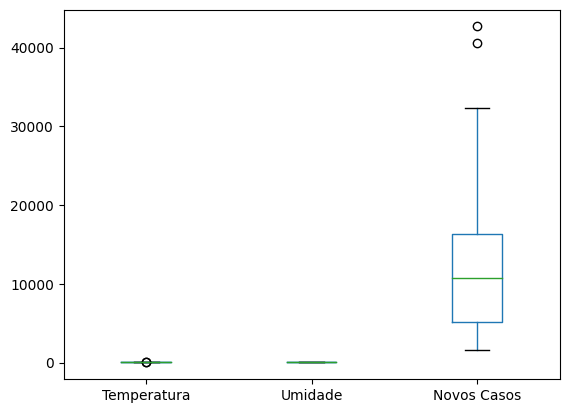

In [ ]:
df_sp_merge_media_teste.plot.box()

In [ ]:
df_corr = df_sp_merge_media_teste.corr()
df_corr

,Temperatura,Umidade,Novos Casos
Temperatura,1.000000,-0.313203,-0.009743
Umidade,-0.313203,1.000000,-0.046671
Novos Casos,-0.009743,-0.046671,1.000000


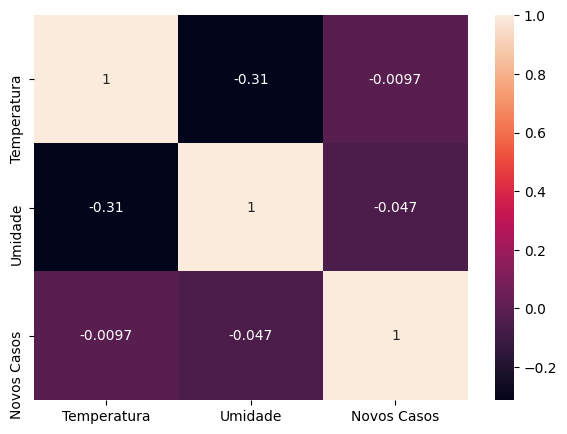

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
hm = sns.heatmap(df_corr, ax = ax, annot=True)

In [ ]:
df_corr_spearman = df_sp_merge_media_teste.corr(method='spearman')
df_corr_spearman

,Temperatura,Umidade,Novos Casos
Temperatura,1.000000,-0.225127,-0.023085
Umidade,-0.225127,1.000000,-0.095855
Novos Casos,-0.023085,-0.095855,1.000000


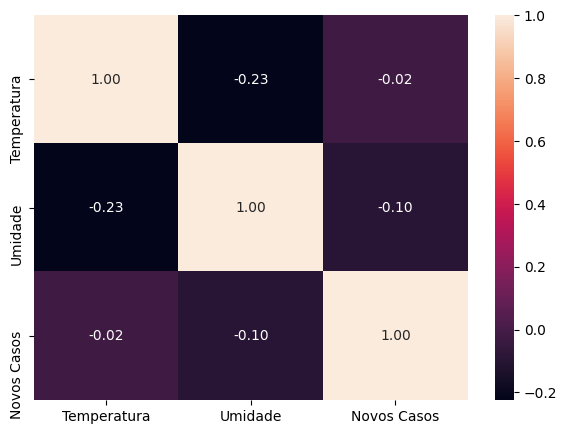

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
hm = sns.heatmap(df_corr_spearman, ax = ax, fmt = '.2f', annot=True)

In [ ]:
df_corr_kendal = df_sp_merge_media_teste.corr(method='kendall')
df_corr_kendal

,Temperatura,Umidade,Novos Casos
Temperatura,1.000000,-0.155870,-0.018056
Umidade,-0.155870,1.000000,-0.064421
Novos Casos,-0.018056,-0.064421,1.000000


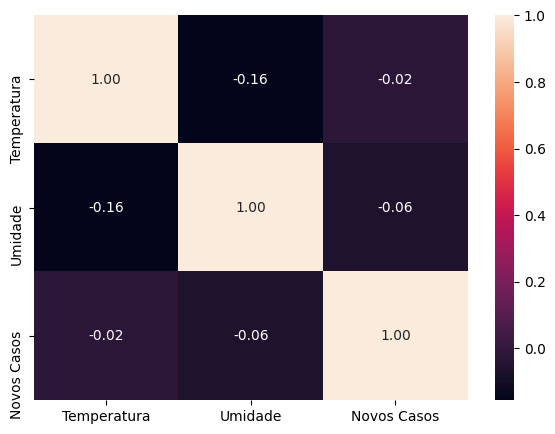

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
hm = sns.heatmap(df_corr_kendal, ax = ax, fmt = '.2f', annot=True)

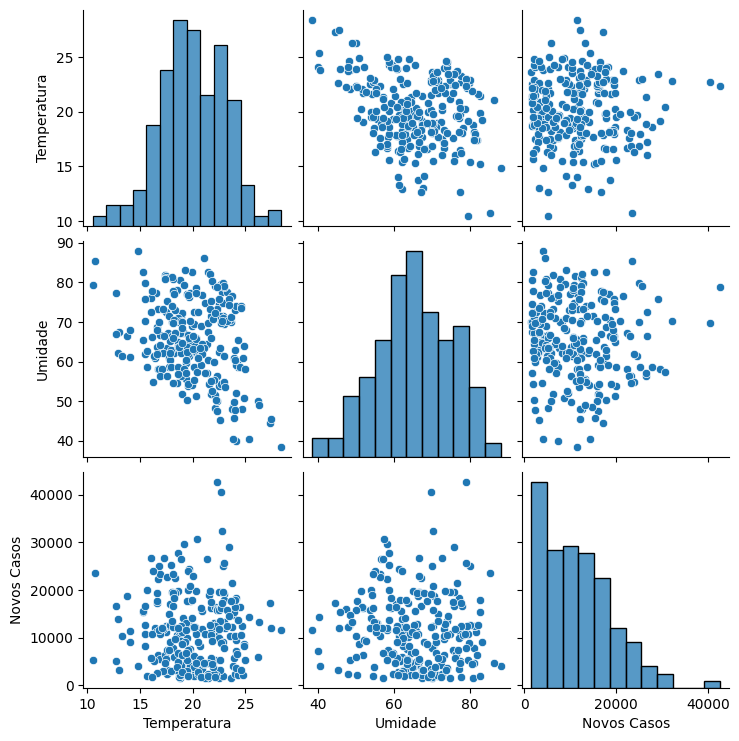

In [ ]:
pairs = sns.pairplot(df_sp_merge_media)

In [ ]:
#Criar features e target 
target = df_sp_merge_media.loc[:,'Novos Casos']
features = df_sp_merge_media.loc[:, 'Temperatura':'Umidade']
#Estimar relação com OLS
result = OLS(target, features, hasconst=False).fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:            Novos Casos   R-squared (uncentered):                   0.689
Model:                            OLS   Adj. R-squared (uncentered):              0.686
Method:                 Least Squares   F-statistic:                              272.2
Date:                Tue, 12 Jan 2021   Prob (F-statistic):                    4.47e-63
Time:                        12:22:14   Log-Likelihood:                         -2570.5
No. Observations:                 248   AIC:                                      5145.
Df Residuals:                     246   BIC:                                      5152.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

<AxesSubplot:xlabel='Temperatura', ylabel='Novos Casos'>

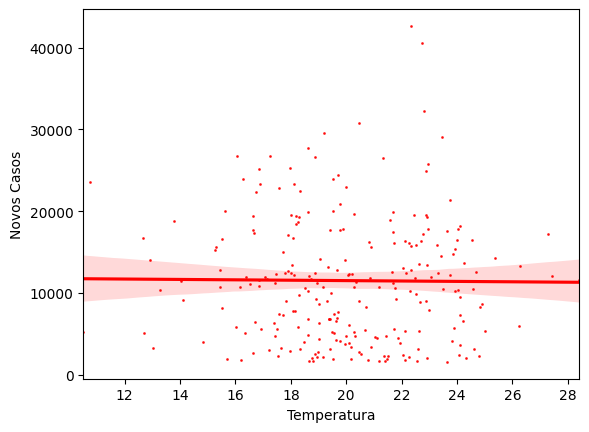

In [ ]:
sns.regplot(x=features.iloc[:,0], y=target, data=df_sp_merge_media,marker='o', color='red', scatter_kws={'s':1})

<AxesSubplot:xlabel='Umidade', ylabel='Novos Casos'>

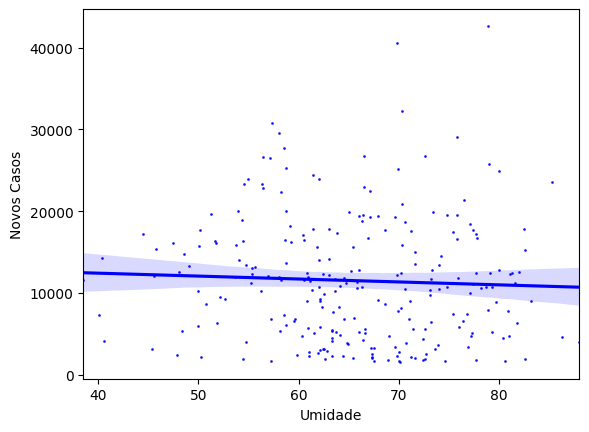

In [ ]:
sns.regplot(x=features.iloc[:,1], y=target, data=df_sp_merge_media,marker='o', color='blue', scatter_kws={'s':1})

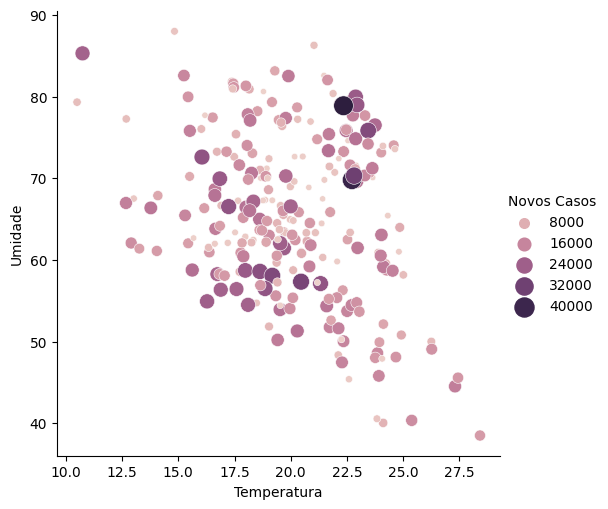

In [ ]:
sns.relplot(x='Temperatura', y='Umidade', hue='Novos Casos' , data=df_sp_merge_media, size="Novos Casos", sizes=(20, 200))

## SEGUNDA ANALISE: Adicionar novas variaveis climatologicas para correlacionar com novos casos confirmados de covid em todos os estados do BR, conforme citadas abaixo:


* PRECIPITAÇÃO TOTAL, HORÁRIO (mm)
* TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)
* UMIDADE RELATIVA DO AR, HORARIA (%)
* VENTO, VELOCIDADE HORARIA (m/s)
* RADIACAO GLOBAL (Kj/m²) 	
* PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)

In [ ]:
weterList2 = [weter_Acre[['Estado','Data','PRECIPITAÇÃO TOTAL, HORÁRIO (mm)','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)','VENTO, VELOCIDADE HORARIA (m/s)','RADIACAO GLOBAL (Kj/m²)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)']],
          weter_Alagoas[['Estado','Data','PRECIPITAÇÃO TOTAL, HORÁRIO (mm)','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)','VENTO, VELOCIDADE HORARIA (m/s)','RADIACAO GLOBAL (Kj/m²)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)']],
          weter_Amapa[['Estado','Data','PRECIPITAÇÃO TOTAL, HORÁRIO (mm)','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)','VENTO, VELOCIDADE HORARIA (m/s)','RADIACAO GLOBAL (Kj/m²)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)']],
          weter_Amazonas[['Estado','Data','PRECIPITAÇÃO TOTAL, HORÁRIO (mm)','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)','VENTO, VELOCIDADE HORARIA (m/s)','RADIACAO GLOBAL (Kj/m²)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)']],
          weter_Bahia[['Estado','Data','PRECIPITAÇÃO TOTAL, HORÁRIO (mm)','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)','VENTO, VELOCIDADE HORARIA (m/s)','RADIACAO GLOBAL (Kj/m²)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)']],
          weter_Ceara[['Estado','Data','PRECIPITAÇÃO TOTAL, HORÁRIO (mm)','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)','VENTO, VELOCIDADE HORARIA (m/s)','RADIACAO GLOBAL (Kj/m²)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)']],
          weter_DistritoFederal[['Estado','Data','PRECIPITAÇÃO TOTAL, HORÁRIO (mm)','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)','VENTO, VELOCIDADE HORARIA (m/s)','RADIACAO GLOBAL (Kj/m²)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)']],
          weter_EspiritoSanto[['Estado','Data','PRECIPITAÇÃO TOTAL, HORÁRIO (mm)','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)','VENTO, VELOCIDADE HORARIA (m/s)','RADIACAO GLOBAL (Kj/m²)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)']],
          weter_Goiais[['Estado','Data','PRECIPITAÇÃO TOTAL, HORÁRIO (mm)','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)','VENTO, VELOCIDADE HORARIA (m/s)','RADIACAO GLOBAL (Kj/m²)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)']],
          weter_Maranhão[['Estado','Data','PRECIPITAÇÃO TOTAL, HORÁRIO (mm)','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)','VENTO, VELOCIDADE HORARIA (m/s)','RADIACAO GLOBAL (Kj/m²)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)']],
          weter_MatoGrosso[['Estado','Data','PRECIPITAÇÃO TOTAL, HORÁRIO (mm)','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)','VENTO, VELOCIDADE HORARIA (m/s)','RADIACAO GLOBAL (Kj/m²)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)']],
          weter_MatoGossoSul[['Estado','Data','PRECIPITAÇÃO TOTAL, HORÁRIO (mm)','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)','VENTO, VELOCIDADE HORARIA (m/s)','RADIACAO GLOBAL (Kj/m²)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)']],
          weter_MinasGerais[['Estado','Data','PRECIPITAÇÃO TOTAL, HORÁRIO (mm)','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)','VENTO, VELOCIDADE HORARIA (m/s)','RADIACAO GLOBAL (Kj/m²)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)']],
          weter_Para[['Estado','Data','PRECIPITAÇÃO TOTAL, HORÁRIO (mm)','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)','VENTO, VELOCIDADE HORARIA (m/s)','RADIACAO GLOBAL (Kj/m²)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)']],
          weter_Paraiba[['Estado','Data','PRECIPITAÇÃO TOTAL, HORÁRIO (mm)','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)','VENTO, VELOCIDADE HORARIA (m/s)','RADIACAO GLOBAL (Kj/m²)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)']],
          weter_Parana[['Estado','Data','PRECIPITAÇÃO TOTAL, HORÁRIO (mm)','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)','VENTO, VELOCIDADE HORARIA (m/s)','RADIACAO GLOBAL (Kj/m²)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)']],
          weter_Pernambuco[['Estado','Data','PRECIPITAÇÃO TOTAL, HORÁRIO (mm)','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)','VENTO, VELOCIDADE HORARIA (m/s)','RADIACAO GLOBAL (Kj/m²)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)']],
          weter_Piaui[['Estado','Data','PRECIPITAÇÃO TOTAL, HORÁRIO (mm)','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)','VENTO, VELOCIDADE HORARIA (m/s)','RADIACAO GLOBAL (Kj/m²)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)']],
          weter_RiodeJaneiro[['Estado','Data','PRECIPITAÇÃO TOTAL, HORÁRIO (mm)','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)','VENTO, VELOCIDADE HORARIA (m/s)','RADIACAO GLOBAL (Kj/m²)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)']],
          weter_RioGrandedoNorte[['Estado','Data','PRECIPITAÇÃO TOTAL, HORÁRIO (mm)','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)','VENTO, VELOCIDADE HORARIA (m/s)','RADIACAO GLOBAL (Kj/m²)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)']],
          weter_RioGrandeSul[['Estado','Data','PRECIPITAÇÃO TOTAL, HORÁRIO (mm)','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)','VENTO, VELOCIDADE HORARIA (m/s)','RADIACAO GLOBAL (Kj/m²)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)']],
          weter_Rondonia[['Estado','Data','PRECIPITAÇÃO TOTAL, HORÁRIO (mm)','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)','VENTO, VELOCIDADE HORARIA (m/s)','RADIACAO GLOBAL (Kj/m²)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)']],
          weter_Roraima[['Estado','Data','PRECIPITAÇÃO TOTAL, HORÁRIO (mm)','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)','VENTO, VELOCIDADE HORARIA (m/s)','RADIACAO GLOBAL (Kj/m²)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)']],
          weter_SantaCatarina[['Estado','Data','PRECIPITAÇÃO TOTAL, HORÁRIO (mm)','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)','VENTO, VELOCIDADE HORARIA (m/s)','RADIACAO GLOBAL (Kj/m²)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)']],
          weter_SaoPaulo[['Estado','Data','PRECIPITAÇÃO TOTAL, HORÁRIO (mm)','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)','VENTO, VELOCIDADE HORARIA (m/s)','RADIACAO GLOBAL (Kj/m²)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)']],
          weter_Sergipe[['Estado','Data','PRECIPITAÇÃO TOTAL, HORÁRIO (mm)','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)','VENTO, VELOCIDADE HORARIA (m/s)','RADIACAO GLOBAL (Kj/m²)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)']],
          weter_Tocantins[['Estado','Data','PRECIPITAÇÃO TOTAL, HORÁRIO (mm)','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','UMIDADE RELATIVA DO AR, HORARIA (%)','VENTO, VELOCIDADE HORARIA (m/s)','RADIACAO GLOBAL (Kj/m²)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)']]
        ]

df_values = pd.concat(weterList2)

df_values['Data']=df_values['Data'].astype(str)

In [ ]:
mean = df_values.groupby(['Estado']).mean()
mean

,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)","UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, VELOCIDADE HORARIA (m/s)",RADIACAO GLOBAL (Kj/m²),"PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)"
Estado,,,,,,
AC,0.212840,25.613128,83.026821,0.993116,1213.130990,990.213708
AL,0.136911,26.235996,71.370135,2.028200,1515.254534,999.255604
AM,0.239484,27.159333,78.819096,0.647764,756.087403,1004.686131
AP,0.273575,26.819378,80.603130,1.818900,1429.165072,1006.010065
BA,0.129444,24.542981,73.309666,2.092925,1431.115288,972.703009
CE,0.103082,26.705454,67.913336,2.296404,1309.751697,982.799429
DF,0.216401,21.586899,67.829051,2.170897,1491.253801,896.376085
ES,0.156049,23.251832,75.843490,2.130572,1204.079853,989.753507
GO,0.170948,24.010432,63.154153,1.362444,1426.799035,931.680692


In [ ]:
std_values = df_values.groupby(['Estado']).std()
std_values

,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)","UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, VELOCIDADE HORARIA (m/s)",RADIACAO GLOBAL (Kj/m²),"PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)"
Estado,,,,,,
AC,0.383003,1.477792,5.232548,0.296901,348.798622,1.975855
AL,0.255373,1.743540,5.696294,0.576359,317.525920,4.147000
AM,0.290053,0.918182,5.288237,0.130440,140.757109,1.415442
AP,0.455252,1.050801,5.860293,0.344835,327.860709,1.416066
BA,0.166207,1.728325,7.091340,0.407103,298.993704,2.558962
CE,0.186273,0.965004,9.961512,0.652741,216.332082,3.491113
DF,0.416081,2.157883,16.543716,0.595087,377.642298,2.171309
ES,0.314495,2.209890,5.895577,0.434932,380.673112,4.229194
GO,0.264834,2.246633,16.089282,0.362092,261.308301,3.010209


In [ ]:
min_values = df_values.groupby(['Estado']).min()
min_values

,Data,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)","UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, VELOCIDADE HORARIA (m/s)",RADIACAO GLOBAL (Kj/m²),"PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)"
Estado,,,,,,,
AC,2020-01-01,0.0,15.829630,65.526316,0.451389,235.132000,983.921138
AL,2020-01-01,0.0,22.613636,56.145833,0.853922,445.401695,988.637500
AM,2020-01-01,0.0,23.879793,64.670455,0.366667,291.490756,1000.166667
AP,2020-01-01,0.0,24.050000,65.750000,0.910870,416.429630,1002.106250
BA,2020-01-01,0.0,20.508506,53.989501,1.160534,563.755052,966.599388
CE,2020-01-01,0.0,24.282028,50.052083,1.008333,596.521429,975.208333
DF,2020-01-01,0.0,16.733333,24.512821,1.168333,384.250649,890.981667
ES,2020-01-01,0.0,18.200000,61.805405,1.255212,287.871429,978.808703
GO,2020-01-01,0.0,17.765273,24.350220,0.776250,680.945640,923.637155


In [ ]:
max_values = df_values.groupby(['Estado']).max()
max_values

,Data,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)","UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, VELOCIDADE HORARIA (m/s)",RADIACAO GLOBAL (Kj/m²),"PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)"
Estado,,,,,,,
AC,2020-12-31,3.955556,28.875758,93.933333,3.318367,2027.076471,998.788889
AL,2020-12-31,2.178571,29.677465,86.156250,3.984524,2102.380556,1007.175532
AM,2020-12-31,2.431156,29.962234,89.328889,1.487912,1086.425868,1008.376923
AP,2020-12-31,3.245833,29.129167,92.166667,2.864583,1966.496154,1010.589286
BA,2020-12-31,0.947064,28.615846,89.613740,3.135220,2010.776712,979.867890
CE,2020-12-31,1.097619,28.805085,86.820312,3.611702,1667.703125,987.914583
DF,2020-12-31,2.858333,28.198333,93.566667,4.015833,2215.678689,902.932500
ES,2020-12-31,2.461702,27.866260,93.421569,3.664740,1999.367262,999.185882
GO,2020-12-31,1.580242,30.943949,87.945489,2.769665,1956.300000,938.201799


In [ ]:
df_values.columns

Index(['Estado', 'Data', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)',
       'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
       'UMIDADE RELATIVA DO AR, HORARIA (%)',
       'VENTO, VELOCIDADE HORARIA (m/s)', 'RADIACAO GLOBAL (Kj/m²)',
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)'],
      dtype='object')

In [ ]:

df_values.rename(columns={
    'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)':'precipitacao_chuva(mm)',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)':'temperatura_ar(°C)',
    'UMIDADE RELATIVA DO AR, HORARIA (%)':'umidade_ar(%)',
    'VENTO, VELOCIDADE HORARIA (m/s)':'velocidade_vento(m/s)',
    'RADIACAO GLOBAL (Kj/m²)':'radiacao_global(Kj/m²)',
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)':'pressao_atmosferica(mB)'},
    inplace=True)

df_final = df_values.groupby('Estado').agg({
                            'precipitacao_chuva(mm)':['mean','std','min','max'],
                            'temperatura_ar(°C)':['mean','std','min','max'],
                            'umidade_ar(%)':['mean','std','min','max'],
                            'velocidade_vento(m/s)':['mean','std','min','max'],
                            'radiacao_global(Kj/m²)':['mean','std','min','max'],
                            'pressao_atmosferica(mB)':['mean','std','min','max'],
                            }).reset_index()

# df_final.to_csv('full_datascience.csv', sep='\t', float_format='%.2f', encoding='utf-8', index=False)

In [ ]:
df_values['Data']= df_values['Data'].astype(str)
df_values.reset_index()
df_values

,Estado,Data,precipitacao_chuva(mm),temperatura_ar(°C),umidade_ar(%),velocidade_vento(m/s),radiacao_global(Kj/m²),pressao_atmosferica(mB)
0,AC,2020-01-01,0.843056,25.202083,90.319444,0.817361,577.865000,987.917361
1,AC,2020-01-02,1.451389,24.213889,89.784722,1.047917,617.320588,989.586806
2,AC,2020-01-03,0.287500,25.537500,84.736111,0.853472,1174.360417,991.147222
3,AC,2020-01-04,1.370833,25.336111,88.611111,0.990278,708.164706,990.450694
4,AC,2020-01-05,0.088889,26.209028,83.368056,1.200694,1073.458824,988.227778
...,...,...,...,...,...,...,...,...
361,TO,2020-12-27,0.088031,25.123166,83.215139,1.046552,1250.833333,977.603475
362,TO,2020-12-28,0.034510,27.138039,73.668000,1.363596,1564.811446,978.205882
363,TO,2020-12-29,0.112782,28.110902,67.490494,1.259167,1733.797714,977.359023
364,TO,2020-12-30,0.045775,28.017606,68.627660,1.144922,1617.909945,977.818662


In [ ]:
df_valuesOLS = df_values.groupby(by=['Data','Estado'])[['precipitacao_chuva(mm)','temperatura_ar(°C)','umidade_ar(%)','velocidade_vento(m/s)','radiacao_global(Kj/m²)','pressao_atmosferica(mB)']].mean()
df_valuesOLS = df_valuesOLS.reset_index()
df_valuesOLS

,Data,Estado,precipitacao_chuva(mm),temperatura_ar(°C),umidade_ar(%),velocidade_vento(m/s),radiacao_global(Kj/m²),pressao_atmosferica(mB)
0,2020-01-01,AC,0.843056,25.202083,90.319444,0.817361,577.865000,987.917361
1,2020-01-01,AL,0.075000,26.807639,74.429577,1.662500,1040.119753,999.371528
2,2020-01-01,AM,0.434903,26.415584,82.062500,0.975325,683.724107,1003.116623
3,2020-01-01,AP,0.419355,26.129032,83.161290,2.038710,1429.223810,1007.206452
4,2020-01-01,BA,0.267684,25.130662,76.965616,1.906990,1317.208347,970.023672
...,...,...,...,...,...,...,...,...
9877,2020-12-31,RS,0.306137,22.459567,72.443742,2.600249,1785.849708,969.180265
9878,2020-12-31,SC,0.499022,22.769472,83.367220,2.033676,1140.241590,935.722896
9879,2020-12-31,SE,0.000000,26.185000,65.941667,1.036458,1614.998507,987.449167
9880,2020-12-31,SP,0.441946,22.345469,78.887960,1.634211,1050.008854,942.301618


In [ ]:
df_valuesOLS['diff_7days'] = df_valuesOLS['Data'].astype('datetime64[ns]') + np.timedelta64(1, 'W')
df_valuesOLS['diff_7days']= df_valuesOLS['diff_7days'].astype(str)
df_valuesOLS['diff_15days'] = df_valuesOLS['Data'].astype('datetime64[ns]') + np.timedelta64(2, 'W')
df_valuesOLS['diff_15days']= df_valuesOLS['diff_15days'].astype(str)
df_valuesOLS

,Data,Estado,precipitacao_chuva(mm),temperatura_ar(°C),umidade_ar(%),velocidade_vento(m/s),radiacao_global(Kj/m²),pressao_atmosferica(mB),diff_7days,diff_15days
0,2020-01-01,AC,0.843056,25.202083,90.319444,0.817361,577.865000,987.917361,2020-01-08,2020-01-15
1,2020-01-01,AL,0.075000,26.807639,74.429577,1.662500,1040.119753,999.371528,2020-01-08,2020-01-15
2,2020-01-01,AM,0.434903,26.415584,82.062500,0.975325,683.724107,1003.116623,2020-01-08,2020-01-15
3,2020-01-01,AP,0.419355,26.129032,83.161290,2.038710,1429.223810,1007.206452,2020-01-08,2020-01-15
4,2020-01-01,BA,0.267684,25.130662,76.965616,1.906990,1317.208347,970.023672,2020-01-08,2020-01-15
...,...,...,...,...,...,...,...,...,...,...
9877,2020-12-31,RS,0.306137,22.459567,72.443742,2.600249,1785.849708,969.180265,2021-01-07,2021-01-14
9878,2020-12-31,SC,0.499022,22.769472,83.367220,2.033676,1140.241590,935.722896,2021-01-07,2021-01-14
9879,2020-12-31,SE,0.000000,26.185000,65.941667,1.036458,1614.998507,987.449167,2021-01-07,2021-01-14
9880,2020-12-31,SP,0.441946,22.345469,78.887960,1.634211,1050.008854,942.301618,2021-01-07,2021-01-14


### 7 ou 15 dias
Alterar a variável diferenca_dias, de acordo com o tempo que deseja-se analizar, 0, 7 ou 15 dias a frente em relação aos novos casos e a temperatura.
A variável por ter os seguites valores: 

diferenca_dias:

        'Data': para valores em tempo real
        'diff_7days': para valores com 7 dias a frente
        'diff_15days': para valores com 7 dias a frente

In [ ]:
diferenca_dias = 'diff_7days'

In [ ]:
df_valuesOLS['Data'] = pd.DatetimeIndex(df_valuesOLS[diferenca_dias]).month
df_valuesOLS = df_valuesOLS.groupby(by=['Data','Estado']).mean().reset_index()
df_valuesOLS

,Data,Estado,precipitacao_chuva(mm),temperatura_ar(°C),umidade_ar(%),velocidade_vento(m/s),radiacao_global(Kj/m²),pressao_atmosferica(mB)
0,1,AC,0.429352,25.788454,84.855029,1.055871,1048.129643,989.066104
1,1,AL,0.031157,27.726262,66.214683,2.599241,1584.313315,998.186857
2,1,AM,0.279606,26.718631,81.136768,0.757054,748.285016,1004.133991
3,1,AP,0.224640,26.228455,82.106798,1.877013,1327.892365,1005.695709
4,1,BA,0.151347,25.982134,69.442562,2.142754,1566.041276,970.668978
...,...,...,...,...,...,...,...,...
319,12,RS,0.183516,22.364992,71.018716,2.533476,1600.352208,971.880329
320,12,SC,0.281524,21.202042,79.240888,2.171797,1322.533373,938.915434
321,12,SE,0.019650,26.127504,66.891009,1.728894,1803.252994,987.398562
322,12,SP,0.180874,23.324442,72.174874,1.903703,1515.578046,941.731191


In [ ]:
df_covid_casos

,date,state,new_confirmed
0,1,AC,3233
1,1,AL,6812
2,1,AM,27082
3,1,AP,5787
4,1,BA,39797
...,...,...,...
293,12,RS,255232
294,12,SC,256478
295,12,SE,44714
296,12,SP,441288


In [ ]:
df_br_mergeOLS = pd.merge(df_covid_casos, df_valuesOLS, left_on= ['date','state'], right_on= ['Data','Estado'] )
df_br_mergeOLS = df_br_mergeOLS[['precipitacao_chuva(mm)','temperatura_ar(°C)','umidade_ar(%)','velocidade_vento(m/s)','radiacao_global(Kj/m²)','pressao_atmosferica(mB)','new_confirmed']]
df_br_mergeOLS = df_br_mergeOLS[df_br_mergeOLS['new_confirmed']>1500]
df_br_mergeOLS

,precipitacao_chuva(mm),temperatura_ar(°C),umidade_ar(%),velocidade_vento(m/s),radiacao_global(Kj/m²),pressao_atmosferica(mB),new_confirmed
0,0.429352,25.788454,84.855029,1.055871,1048.129643,989.066104,3233
1,0.031157,27.726262,66.214683,2.599241,1584.313315,998.186857,6812
2,0.279606,26.718631,81.136768,0.757054,748.285016,1004.133991,27082
3,0.224640,26.228455,82.106798,1.877013,1327.892365,1005.695709,5787
4,0.151347,25.982134,69.442562,2.142754,1566.041276,970.668978,39797
...,...,...,...,...,...,...,...
293,0.183516,22.364992,71.018716,2.533476,1600.352208,971.880329,255232
294,0.281524,21.202042,79.240888,2.171797,1322.533373,938.915434,256478
295,0.019650,26.127504,66.891009,1.728894,1803.252994,987.398562,44714
296,0.180874,23.324442,72.174874,1.903703,1515.578046,941.731191,441288


<AxesSubplot:>

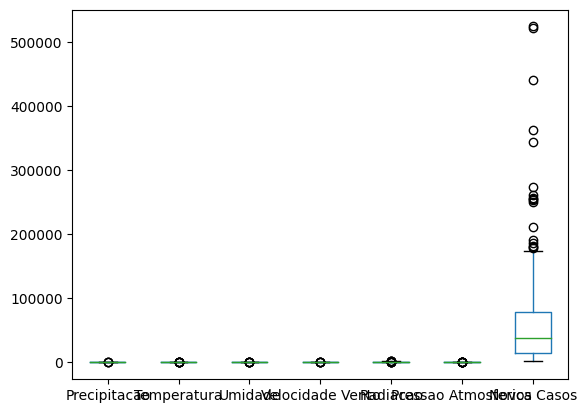

In [ ]:
df_br_mergeOLS.columns = ['Precipitacao', 'Temperatura','Umidade','Velocidade Vento','Radiacao','Pressao Atmosferica','Novos Casos']
df_br_mergeOLS[['Precipitacao', 'Temperatura','Umidade','Velocidade Vento','Radiacao','Pressao Atmosferica','Novos Casos']].plot.box()

<AxesSubplot:>

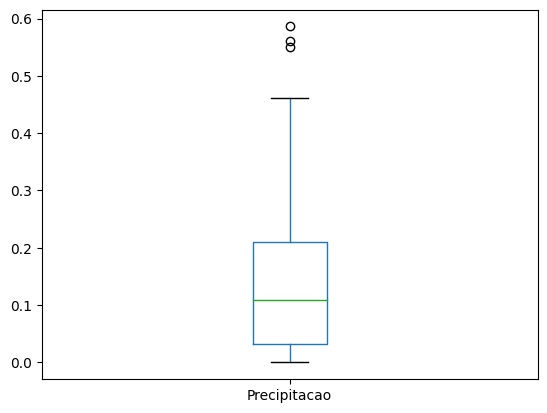

In [ ]:
df_br_mergeOLS[['Precipitacao',]].plot.box()

<AxesSubplot:>

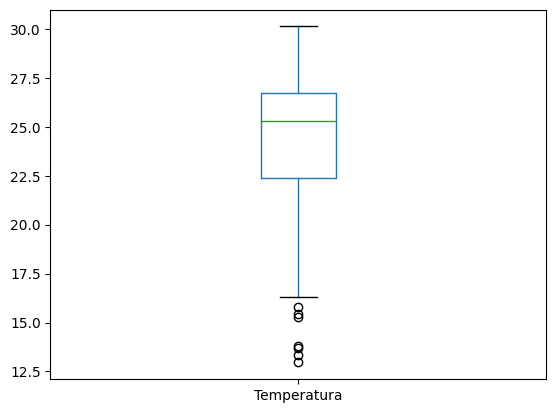

In [ ]:
df_br_mergeOLS[['Temperatura',]].plot.box()

<AxesSubplot:>

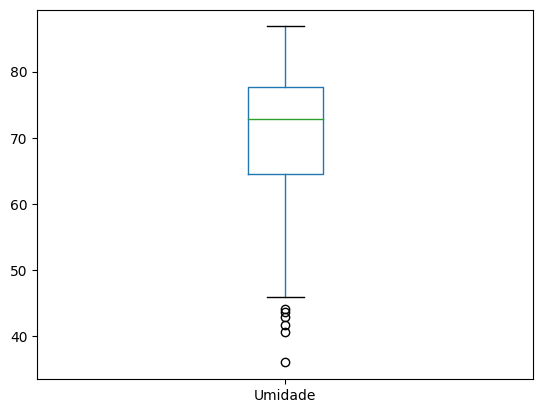

In [ ]:
df_br_mergeOLS[['Umidade',]].plot.box()

<AxesSubplot:>

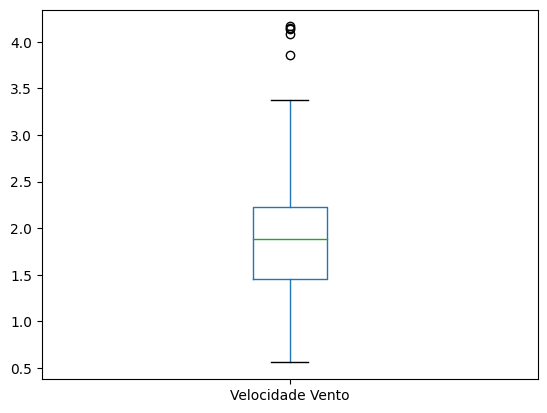

In [ ]:
df_br_mergeOLS[['Velocidade Vento',]].plot.box()

<AxesSubplot:>

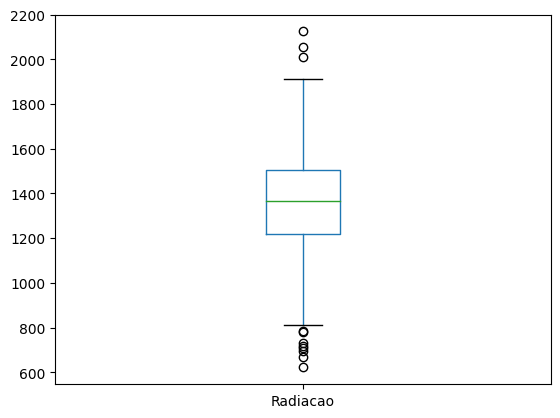

In [ ]:
df_br_mergeOLS[['Radiacao',]].plot.box()

<AxesSubplot:>

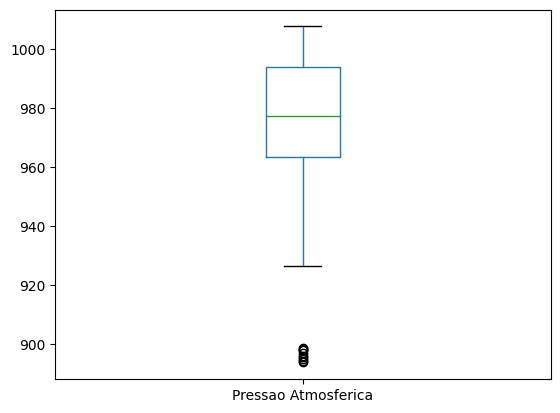

In [ ]:
df_br_mergeOLS[['Pressao Atmosferica',]].plot.box()

<AxesSubplot:>

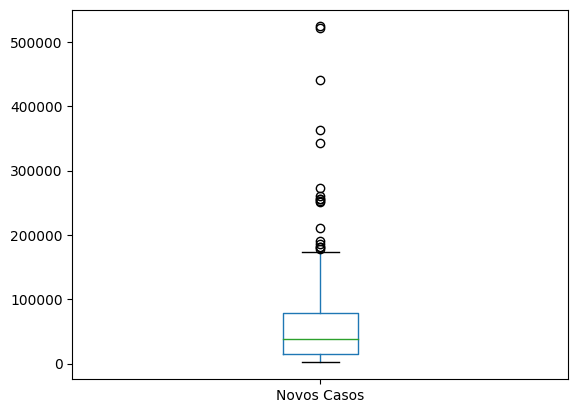

In [ ]:
df_br_mergeOLS[['Novos Casos']].plot.box()

In [ ]:
df_br_z_OLS = (df_br_mergeOLS['Novos Casos'] - df_br_mergeOLS['Novos Casos'].mean())/df_br_mergeOLS['Novos Casos'].std()
df_br_z_OLS = df_br_z_OLS.sort_values()
df_br_z_OLS.tail(15)

167    1.568494
140    1.628296
186    1.692503
267    1.958521
269    2.487690
281    2.515251
293    2.542653
294    2.559037
242    2.618471
288    2.775812
134    3.701504
215    3.954070
296    4.989110
161    6.048395
188    6.077691
Name: Novos Casos, dtype: float64

In [ ]:
df_br_mergeOLS = df_br_mergeOLS.drop([188,161,296,215,134,288,242,294,293,281,269,267,186,140,167,275,173,25,146,107,289,200,198,266])

<AxesSubplot:>

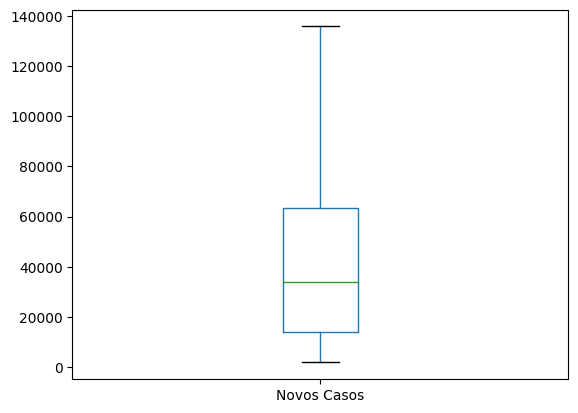

In [ ]:
df_br_mergeOLS[['Novos Casos']].plot.box()

# CORRELAÇÃO DE PEARSON

## Correlação de Pearson: [Novos Casos] x [Variaveis Climatologicas]


> Nossa escolha para usar em nossos resultados do trabalho foi a correlação de Pearson, porém analisamos os resultados das 3 para entender qual a que se aplicava melhor aos nossos dados.

In [ ]:
df_corr_pearson_br_OLS = df_br_mergeOLS.corr(method='pearson')
df_corr_pearson_br_OLS

,Precipitacao,Temperatura,Umidade,Velocidade Vento,Radiacao,Pressao Atmosferica,Novos Casos
Precipitacao,1.000000,0.011099,0.665895,-0.366990,-0.380316,0.109813,-0.108179
Temperatura,0.011099,1.000000,-0.222316,-0.103088,0.404222,0.514672,-0.405991
Umidade,0.665895,-0.222316,1.000000,-0.422497,-0.533570,0.259577,-0.118658
Velocidade Vento,-0.366990,-0.103088,-0.422497,1.000000,0.465393,-0.159953,0.108529
Radiacao,-0.380316,0.404222,-0.533570,0.465393,1.000000,-0.066969,-0.068968
Pressao Atmosferica,0.109813,0.514672,0.259577,-0.159953,-0.066969,1.000000,-0.343532
Novos Casos,-0.108179,-0.405991,-0.118658,0.108529,-0.068968,-0.343532,1.000000


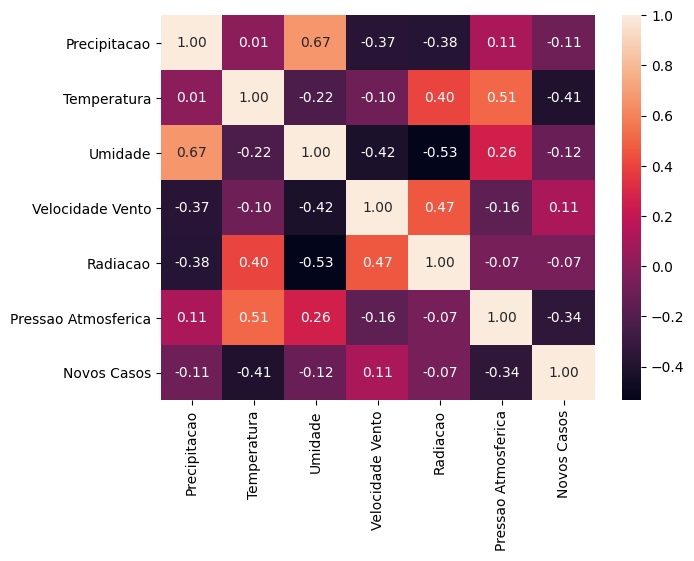

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
hm = sns.heatmap(df_corr_pearson_br_OLS, ax = ax, fmt = '.2f', annot=True)

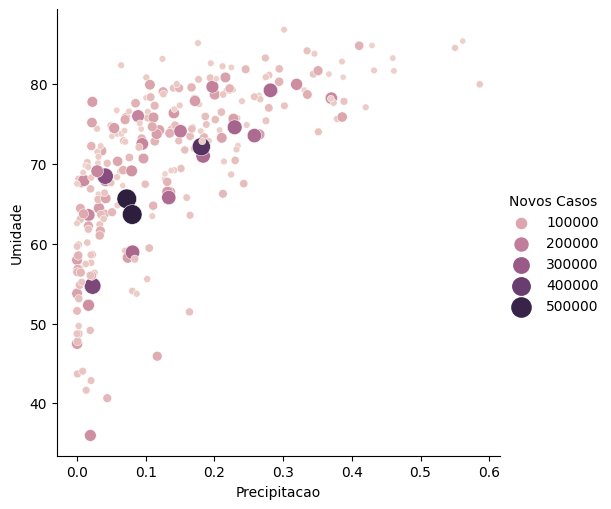

In [ ]:
sns.relplot(x='Precipitacao', y='Umidade', hue='Novos Casos' , data=df_br_mergeOLS, size="Novos Casos", sizes=(20, 200))

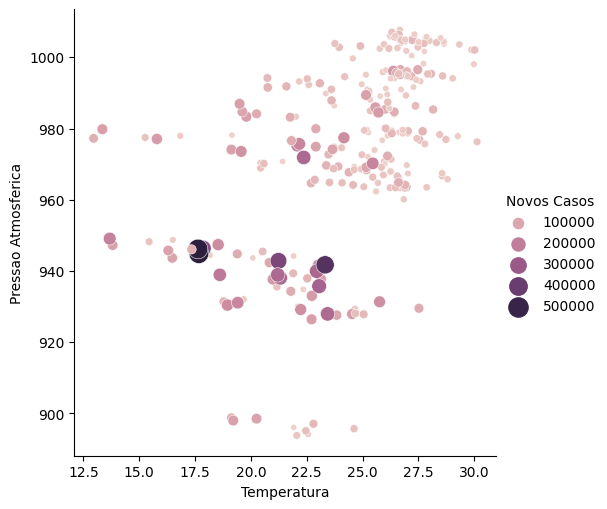

In [ ]:
sns.relplot(x='Temperatura', y='Pressao Atmosferica', hue='Novos Casos' , data=df_br_mergeOLS, size="Novos Casos", sizes=(20, 200))

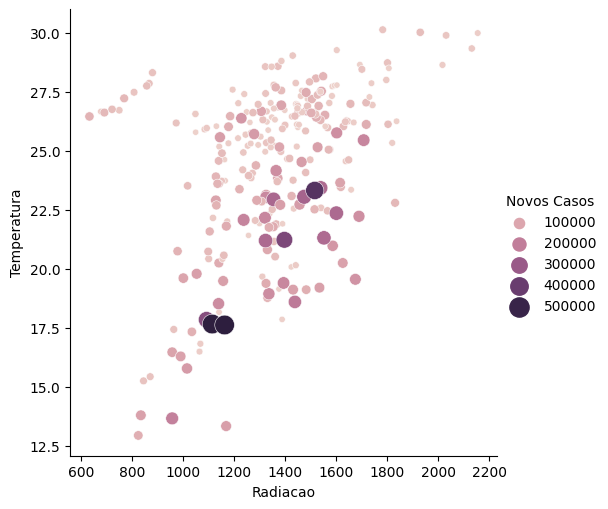

In [ ]:
sns.relplot(x='Radiacao', y='Temperatura', hue='Novos Casos' , data=df_br_mergeOLS, size="Novos Casos", sizes=(20, 200))

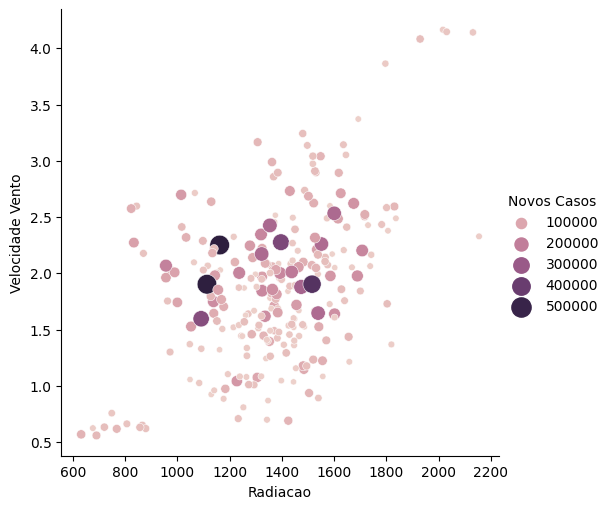

In [ ]:
sns.relplot(x='Radiacao', y='Velocidade Vento', hue='Novos Casos' , data=df_br_mergeOLS, size="Novos Casos", sizes=(20, 200))

## Correlação de Kendall: [Novos Casos] x [Variaveis Climatologicas]

In [ ]:
df_corr_kendall_br_OLS = df_br_mergeOLS.corr(method='kendall')
df_corr_kendall_br_OLS

,Precipitacao,Temperatura,Umidade,Velocidade Vento,Radiacao,Pressao Atmosferica,Novos Casos
Precipitacao,1.000000,-0.048359,0.564919,-0.229437,-0.273578,0.086737,-0.105126
Temperatura,-0.048359,1.000000,-0.138343,-0.114820,0.270567,0.376478,-0.256523
Umidade,0.564919,-0.138343,1.000000,-0.302049,-0.384259,0.208019,-0.142830
Velocidade Vento,-0.229437,-0.114820,-0.302049,1.000000,0.233026,-0.170478,0.132256
Radiacao,-0.273578,0.270567,-0.384259,0.233026,1.000000,-0.037422,-0.053312
Pressao Atmosferica,0.086737,0.376478,0.208019,-0.170478,-0.037422,1.000000,-0.227595
Novos Casos,-0.105126,-0.256523,-0.142830,0.132256,-0.053312,-0.227595,1.000000


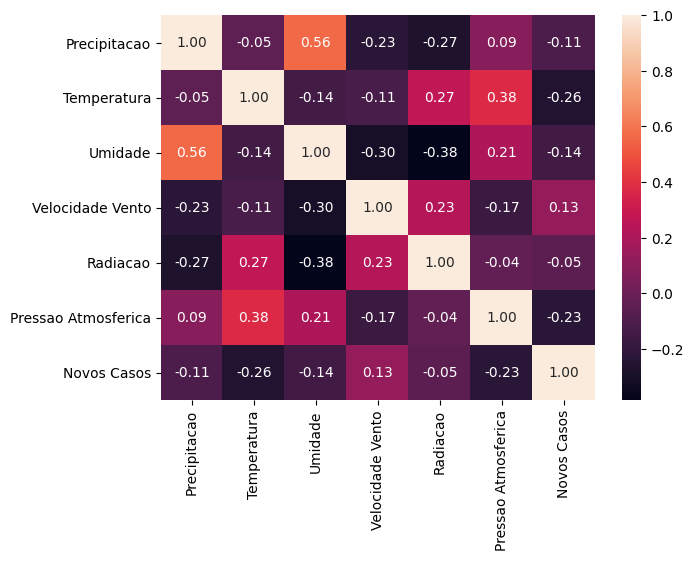

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
hm = sns.heatmap(df_corr_kendall_br_OLS, ax = ax, fmt = '.2f', annot=True)

## Correlação de Spearman: [Novos Casos] x [Variaveis Climatologicas]

In [ ]:
df_corr_spearman_br_OLS = df_br_mergeOLS.corr(method='spearman')
df_corr_spearman_br_OLS

,Precipitacao,Temperatura,Umidade,Velocidade Vento,Radiacao,Pressao Atmosferica,Novos Casos
Precipitacao,1.000000,-0.074970,0.765102,-0.329734,-0.409974,0.135073,-0.157828
Temperatura,-0.074970,1.000000,-0.211866,-0.149283,0.377621,0.566254,-0.379248
Umidade,0.765102,-0.211866,1.000000,-0.431746,-0.562189,0.307218,-0.219631
Velocidade Vento,-0.329734,-0.149283,-0.431746,1.000000,0.343194,-0.254500,0.213929
Radiacao,-0.409974,0.377621,-0.562189,0.343194,1.000000,-0.045611,-0.081416
Pressao Atmosferica,0.135073,0.566254,0.307218,-0.254500,-0.045611,1.000000,-0.339610
Novos Casos,-0.157828,-0.379248,-0.219631,0.213929,-0.081416,-0.339610,1.000000


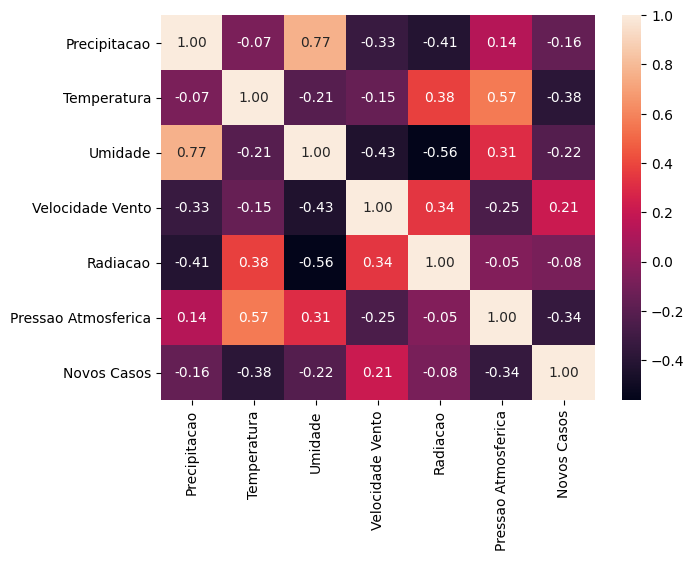

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
hm = sns.heatmap(df_corr_spearman_br_OLS, ax = ax, fmt = '.2f', annot=True)

In [ ]:
pairs = sns.pairplot(df_br_mergeOLS)


In [ ]:
df_br_mergeOLS = df_br_mergeOLS.dropna(how='any',axis=0) 


In [ ]:
#Criar features e target 
target = df_br_mergeOLS.loc[:,'Novos Casos']
features = df_br_mergeOLS.loc[:, 'Precipitacao':'Pressao Atmosferica']
#Estimar relação com OLS
result = OLS(target, features, hasconst=False).fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:            Novos Casos   R-squared (uncentered):                   0.668
Model:                            OLS   Adj. R-squared (uncentered):              0.659
Method:                 Least Squares   F-statistic:                              76.85
Date:                Tue, 12 Jan 2021   Prob (F-statistic):                    4.25e-52
Time:                        12:22:33   Log-Likelihood:                         -2771.6
No. Observations:                 235   AIC:                                      5555.
Df Residuals:                     229   BIC:                                      5576.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

In [ ]:
#Criar features e target 
target = df_br_mergeOLS.loc[:,'Novos Casos']
features = df_br_mergeOLS.loc[:, 'Precipitacao':'Temperatura']
#Estimar relação com OLS
result = OLS(target, features, hasconst=False).fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:            Novos Casos   R-squared (uncentered):                   0.564
Model:                            OLS   Adj. R-squared (uncentered):              0.560
Method:                 Least Squares   F-statistic:                              150.6
Date:                Tue, 12 Jan 2021   Prob (F-statistic):                    1.02e-42
Time:                        12:22:33   Log-Likelihood:                         -2803.7
No. Observations:                 235   AIC:                                      5611.
Df Residuals:                     233   BIC:                                      5618.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [ ]:
#Criar features e target 
target = df_br_mergeOLS.loc[:,'Novos Casos']
features = df_br_mergeOLS.loc[:, 'Precipitacao':'Umidade']
#Estimar relação com OLSU
result = OLS(target, features, hasconst=False).fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:            Novos Casos   R-squared (uncentered):                   0.609
Model:                            OLS   Adj. R-squared (uncentered):              0.604
Method:                 Least Squares   F-statistic:                              120.4
Date:                Tue, 12 Jan 2021   Prob (F-statistic):                    4.73e-47
Time:                        12:22:33   Log-Likelihood:                         -2790.8
No. Observations:                 235   AIC:                                      5588.
Df Residuals:                     232   BIC:                                      5598.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [ ]:
#Criar features e target 
target = df_br_mergeOLS.loc[:,'Novos Casos']
features = df_br_mergeOLS.loc[:, 'Precipitacao':'Velocidade Vento']
#Estimar relação com OLS
result = OLS(target, features, hasconst=False).fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:            Novos Casos   R-squared (uncentered):                   0.624
Model:                            OLS   Adj. R-squared (uncentered):              0.617
Method:                 Least Squares   F-statistic:                              95.66
Date:                Tue, 12 Jan 2021   Prob (F-statistic):                    7.20e-48
Time:                        12:22:33   Log-Likelihood:                         -2786.4
No. Observations:                 235   AIC:                                      5581.
Df Residuals:                     231   BIC:                                      5595.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [ ]:
#Criar features e target 
target = df_br_mergeOLS.loc[:,'Novos Casos']
features = df_br_mergeOLS.loc[:,'Velocidade Vento':'Radiacao']
#Estimar relação com OLS
result = OLS(target, features, hasconst=False).fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:            Novos Casos   R-squared (uncentered):                   0.589
Model:                            OLS   Adj. R-squared (uncentered):              0.585
Method:                 Least Squares   F-statistic:                              166.7
Date:                Tue, 12 Jan 2021   Prob (F-statistic):                    1.16e-45
Time:                        12:22:33   Log-Likelihood:                         -2796.8
No. Observations:                 235   AIC:                                      5598.
Df Residuals:                     233   BIC:                                      5605.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [ ]:
#Criar features e target 
target = df_br_mergeOLS.loc[:,'Novos Casos']
features = df_br_mergeOLS.loc[:, 'Precipitacao':'Radiacao']
#Estimar relação com OLS
result = OLS(target, features, hasconst=False).fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:            Novos Casos   R-squared (uncentered):                   0.624
Model:                            OLS   Adj. R-squared (uncentered):              0.615
Method:                 Least Squares   F-statistic:                              76.22
Date:                Tue, 12 Jan 2021   Prob (F-statistic):                    7.34e-47
Time:                        12:22:33   Log-Likelihood:                         -2786.4
No. Observations:                 235   AIC:                                      5583.
Df Residuals:                     230   BIC:                                      5600.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [ ]:
#Criar features e target 
target = df_br_mergeOLS.loc[:,'Novos Casos']
features = df_br_mergeOLS.loc[:,'Temperatura':'Radiacao']
#Estimar relação com OLS
result = OLS(target, features, hasconst=False).fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:            Novos Casos   R-squared (uncentered):                   0.605
Model:                            OLS   Adj. R-squared (uncentered):              0.598
Method:                 Least Squares   F-statistic:                              88.48
Date:                Tue, 12 Jan 2021   Prob (F-statistic):                    1.77e-45
Time:                        12:22:33   Log-Likelihood:                         -2792.0
No. Observations:                 235   AIC:                                      5592.
Df Residuals:                     231   BIC:                                      5606.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [ ]:
#Criar features e target 
target = df_br_mergeOLS.loc[:,'Novos Casos']
features = df_br_mergeOLS.loc[:,'Temperatura':'Velocidade Vento']
#Estimar relação com OLS
result = OLS(target, features, hasconst=False).fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:            Novos Casos   R-squared (uncentered):                   0.605
Model:                            OLS   Adj. R-squared (uncentered):              0.599
Method:                 Least Squares   F-statistic:                              118.2
Date:                Tue, 12 Jan 2021   Prob (F-statistic):                    1.71e-46
Time:                        12:22:33   Log-Likelihood:                         -2792.2
No. Observations:                 235   AIC:                                      5590.
Df Residuals:                     232   BIC:                                      5601.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [ ]:
#Criar features e target 
target = df_br_mergeOLS.loc[:,'Novos Casos']
features = df_br_mergeOLS.loc[:,'Temperatura':'Pressao Atmosferica']
#Estimar relação com OLS
result = OLS(target, features, hasconst=False).fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:            Novos Casos   R-squared (uncentered):                   0.667
Model:                            OLS   Adj. R-squared (uncentered):              0.660
Method:                 Least Squares   F-statistic:                              92.26
Date:                Tue, 12 Jan 2021   Prob (F-statistic):                    5.61e-53
Time:                        12:22:33   Log-Likelihood:                         -2771.9
No. Observations:                 235   AIC:                                      5554.
Df Residuals:                     230   BIC:                                      5571.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

In [ ]:
### Resultados interessantes!

#Criar features e target 
target = df_br_mergeOLS.loc[:,'Novos Casos']
features = df_br_mergeOLS.loc[:,'Umidade':'Velocidade Vento']
#Estimar relação com OLS
result = OLS(target, features, hasconst=False).fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:            Novos Casos   R-squared (uncentered):                   0.602
Model:                            OLS   Adj. R-squared (uncentered):              0.599
Method:                 Least Squares   F-statistic:                              176.5
Date:                Tue, 12 Jan 2021   Prob (F-statistic):                    2.13e-47
Time:                        12:22:33   Log-Likelihood:                         -2792.8
No. Observations:                 235   AIC:                                      5590.
Df Residuals:                     233   BIC:                                      5596.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [ ]:
#Criar features e target 
target = df_br_mergeOLS.loc[:,'Novos Casos']
features = df_br_mergeOLS.loc[:,'Umidade':'Pressao Atmosferica']
#Estimar relação com OLS
result = OLS(target, features, hasconst=False).fit()
print(result.summary())

In [ ]:
#Criar features e target 
target = df_br_mergeOLS.loc[:,'Novos Casos']
features = df_br_mergeOLS.loc[:, 'Precipitacao':'Umidade']
#Estimar relação com OLS
result = OLS(target, features, hasconst=False).fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:            Novos Casos   R-squared (uncentered):                   0.609
Model:                            OLS   Adj. R-squared (uncentered):              0.604
Method:                 Least Squares   F-statistic:                              120.4
Date:                Tue, 12 Jan 2021   Prob (F-statistic):                    4.73e-47
Time:                        12:22:33   Log-Likelihood:                         -2790.8
No. Observations:                 235   AIC:                                      5588.
Df Residuals:                     232   BIC:                                      5598.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------